In [1]:
using Revise
using Pkg; Pkg.activate(".")

using Dates
using Statistics # limited set of methods included in Julia Base
using StatsBase  # extends Statistics with more functions
using Rotations
# using SignalAlignment
using Interpolations
using PyPlot
using JLD2
# using MAT

using Optim
# using Flux

include("./readers.jl")
using .ShipPosmv

include("./read_lidar.jl")
using .read_vecnav: read_vecnav_dict

include("./timing_lidar.jl")
using .timing_lidar

  Activating project at `~/Projects/ASTRAL/lidar`


In [2]:
# helper functions
pd = permutedims
m2n(x) = ismissing(x) ? NaN : x

anom(x; dims=1) = x .- mean(x; dims=dims)

# functional wrapper for PyPlot plot
plotf(f::Function, x, va...) = plot(x, f.(x), va...)

plotf (generic function with 1 method)

In [3]:
# timing functions # MOVED to timing_lidar.jl module timing_lidar

#=
# Define the GPS epoch
const GPS_EPOCH = DateTime(1980, 1, 6) # DateTime
# const GPS_OFFSET = Dates.datetime2epochms(GPS_EPOCH) # Integer time interval since DateTime epoch

# Function to calculate the number of leap seconds between two dates
function leap_seconds(date::DateTime)
    leap_seconds_list = [
        DateTime(1981, 7, 1), DateTime(1982, 7, 1), DateTime(1983, 7, 1),
        DateTime(1985, 7, 1), DateTime(1988, 1, 1), DateTime(1990, 1, 1),
        DateTime(1991, 1, 1), DateTime(1992, 7, 1), DateTime(1993, 7, 1),
        DateTime(1994, 7, 1), DateTime(1996, 1, 1), DateTime(1997, 7, 1),
        DateTime(1999, 1, 1), DateTime(2006, 1, 1), DateTime(2009, 1, 1),
        DateTime(2012, 7, 1), DateTime(2015, 7, 1), DateTime(2017, 1, 1)
    ]
    return count(ls -> ls <= date, leap_seconds_list)
end

# "convert gpstime (nanoseconds) to DateTime"
# function gps2dt(gpstime::Integer)
#     t_d = floor(gpstime / (86_400 * 1_000_000_000)) # nanosecond -> integer day
#     t_ms = round(Int64, (gpstime % (86_400 * 1_000_000_000) ) / 1_000_000 - 1_000*leap_seconds(t_d)) # nansecond -> millisecond of day
#     GPS_EPOCH + Day(t_d) + Millisecond(t_ms)
# end

"convert gpstime (nanoseconds) to DateTime."
function gps2dt(gpstime::Integer)
    # leap seconds not needed when using time elapsed
    # Millisecond(Integer) -> millisecond timedelta
    GPS_EPOCH + Millisecond(round(Int64, gpstime / 1_000_000))
end

"convert gpstime (nanoseconds) to DateTime epoch milliseconds (integer)."
function gps2ms(gpstime::Integer)
    round(Int64, gpstime / 1_000_000 ) + Dates.datetime2epochms(GPS_EPOCH)
end

dt2gpsns(dt) = Dates.value(Millisecond( dt-GPS_EPOCH )) * 1_000_000 # -> Integer
GPS_MORETHAN = dt2gpsns(DateTime(2024,1,1))

# tests
Dates.datetime2epochms(DateTime(0)) # 0 OK
Dates.epochms2datetime( Dates.datetime2epochms(GPS_EPOCH) ) # 1980-01-06T00:00:00 OK
gps2dt( dt2gpsns(DateTime(2024,4,29,5,25,42,128)) ) # 2024-04-29T05:25:42.128 OK
DateTime(0) + Millisecond(gps2ms( dt2gpsns(DateTime(2024,4,29,5,25,42,128)) )) # 2024-04-29T05:25:42.128 OK
DateTime(0) + Millisecond( 63881587542128 ) # # 2024-04-29T05:25:42.128 OK
gps2ms( dt2gpsns(DateTime(2024,4,29,5,25,42,128)) ) # 63881587542128 OK

"""
itp(dtq) = interpolatedt(dtk, xk, Gridded(Linear()))(Dates.datetime2epochms(dtq))
interpolate using datetimes as coordinates
"""
interpolatedt(dt, x...) = interpolate(Dates.datetime2epochms(dt), x...)

"short wrapper for Dates.value(Millisecond(t))"
DVM(t::TimePeriod) = Dates.value(Millisecond(t))
DVM(t::Integer) = Dates.value(Millisecond(t))
DVM(t::Real) = DVM(round(Int64,t))
DVM(t::AbstractVector{T}) where T<:TimePeriod = DVM.(t)
function DVM(dt::DateTime)
    error("do not use DVM(::DateTime)")
end

"""
Millisecond( round(Integer, v) )
Convert a number to a Millisecond, rounding if necessary. Quasi-inverse of DVM.
"""
MRi(v::Number) = Millisecond( round(Integer, v) ) # convert a number to a Millisecond, rounding if necessary

"""
Interpolate between imprecisely recorded jumps in time.
Need Float64 precision for interpolation
"""
function intbetweentime(prectime::Vector{Float64})
    # monotonic, OK
    ii0 = map(x-> x<=0, diff(prectime)) 
    # ind0 = boolean 1 for imprecise times that should be interpolated
    ind0 = [0; findall(ii0)] .+ 1   # interpolate to these, increment because of diff()
    ind1 = findall(.!ii0) .+ 1 # interpolate from these

    # interpolate (and extrapolate) the inbetween times
    itp = extrapolate( 
            interpolate((ind1,), prectime[ind1], Gridded(Linear())), 
            Line() )
    # fltind0 = filter(i-> i>ind1[1] && i<ind1[end], ind0)
    # prectime[fltind0] = itp(fltind0)
    prectime[ind0] .= itp(ind0)
    # or just just reinterp all indices
    # prectime = itp(axes(prectime))
    return prectime
end


# methods for averaging DateTimes and TimePeriod

"meandt(dt, ...)"
function meandt(dt::AbstractVector{DateTime}, args...)
    ms = @. Dates.value(Millisecond(dt - dt[1]))
    return dt[1] .+ Millisecond(round(Int64, mean(ms, args...)))
end
# "mean for datetimes" updated 2024-08-01
# meandt(dt::AbstractVector{DateTime}) = first(dt) + MRi( mean(DVM.(dt .- first(dt))) )
"meandt(t, ...)"
function meandt(dt::AbstractVector{T}, args...) where T<:TimePeriod
    ms = @. Dates.value(Millisecond(dt))
    return Millisecond(round(Int64, mean(ms, args...)))
end

"interpolate and add offsets to DateTime of precise time from vectornav."
function precise_dt(vn_raw_dt, gpstime)
    RASP_BASE_TIME = floor(vn_raw_dt[1], Dates.Day(1)) # totally bogus unset offset clock time
    # need Float64 precision for interpolation
    # RASP_BASE_TIME is a datetime before the start of the data.
    
    # add offsets
    prectime = intbetweentime( Float64.(DVM( vn_raw_dt .- RASP_BASE_TIME )) )
    precdt_vn_clock = RASP_BASE_TIME .+ Dates.Millisecond.(round.(Int64, prectime))
    offset_gps_vn = gps2dt(gpstime[1]) - precdt_vn_clock[1] # OK for leg 1
    precdt = precdt_vn_clock + offset_gps_vn # move to absolute GPS clock
    return precdt
    # next linearly stretch to minimize bias from GPS
end

"""
Stretch VectorNav millisecond-interpolated
time linearly to match best GPS times at 
the start and 0-1 minute after the reset.
"""
function stretch_vn_to_gps(precdt, gpstime)
    i0 = 2 # step starting good GPS times
    ir = iregress(gpstime)[1]+1 # step after GPS reset
    # delta = meandt(gps2dt.(gpstime[ir:(ir+1200)])) - meandt(precdt[ir:(ir+1200)])
    delta = meandt(gps2dt.(gpstime[ir:(ir+200)])) - meandt(precdt[ir:(ir+200)])
    buildup = range(start=0, length=length(precdt), step=DVM(delta)/(ir+600))
    vntime = @. precdt + Millisecond(round(Int64,buildup))
    return vntime # DateTime
end

"shift, interp, and stretch a time axis to match the GPS"
gpstime2gpsvndt(time, gpstime) = stretch_vn_to_gps( precise_dt(time, gpstime), gpstime )
"subtract leap seconds to get UTC time from GPS time"
gps2utc(gpsdt) = gpsdt - Second(leap_seconds(DateTime(gpsdt)))
gpstime2utcvndt(time, gpstime) = gps2utc( gpstime2gpsvndt(time, gpstime) )

# POSMV timing

"convert the GPS time from the POSMV PASHR message to a DateTime"
function pashr_gps_datetime(pashrtime, gpstime)
    gps_diff_12 = Millisecond(gpstime - (Time(pashrtime) - Hour(12)))
    gps_diff = mod(gps_diff_12, Day(1)) - Hour(12)
    gpsdt = pashrtime + gps_diff
    #DateTime(Date(pashrtime)) 
       #  + ( Millisecond.(gpstime - Time(pashrtime))
end

# # Concatenate variables from two Dicts into 1 Dict
# # --> now in module readers of readers.jl

# """
# Concatenate Array variables from two Dicts into one
# along the dimension dim
# that are values of the same key of dict1 and dict2.
# """
# function cat_dicts(dict1::Dict, dict2::Dict; dim=1)
#     result_dict = typeof(dict1)()
#     for key in intersect( keys(dict1), keys(dict2) )
#         result_dict[key] = cat(dict1[key], dict2[key], dims=dim)
#     end
#     return result_dict
# end
=#

from file: `vectornav.h`

```
#define IDX_TIMEGPS 0
#define IDX_YAW 1
#define IDX_PITCH 2
#define IDX_ROLL 3
#define IDX_QUAT0 4
#define IDX_QUAT1 5
#define IDX_QUAT2 6
#define IDX_QUAT3 7
#define IDX_LATITUDE 8
#define IDX_LONGITUDE 9
#define IDX_ALTITUDE 10
#define IDX_MAGNED0 11
#define IDX_MAGNED1 12
#define IDX_MAGNED2 13
#define IDX_LINACC0 14
#define IDX_LINACC1 15
#define IDX_LINACC2 16
#define IDX_VELNED0 17
#define IDX_VELNED1 18
#define IDX_VELNED2 19
```

```
from file:  vectornav.cpp

  shared_memory->name(
    "GpsTime",
    "Yaw", "Pitch", "Roll",
    "Quat0", "Quat1", "Quat2", "Quat3",
    "Latitude", "Longitude", "Altitude",
    "MagNED0", "MagNED1", "MagNED2",
    "LinAcc0", "LinAcc1", "LinAcc2",
    "VelNED0", "VelNED1", "VelNED2");
```
To decode these variables, you need to look at the VectorNav variable description located in \ceees-lidar-platform-master\lib-src\vnproglib-1.1\index.html
under sensor class.

In [4]:
# functions to read the VectorNav file # MOVED to read_lidar
#=
# line:
# Tue Mar 28 13:17:11 2023 +0000, 9431257000, -163.267792, -1.067281, -1.441135, -0.011044, 0.011087, -0.989255, 0.145364, 0.000000, 0.000000, 0.000000, 0.234963, -0.005458, 0.101274, 0.432598, -0.534912, -9.797964, 0.000000, 0.000000, 0.000000
#
# 21 science data fields delimited by commas

function read_vecnav_data( file::AbstractString )
    # allocate arrays
    nlmax = countlines(file)
    dt = Vector{DateTime}(undef, nlmax)
    intdata = Matrix{Int64}(undef, nlmax, 2)
    data = Matrix{Float32}(undef, nlmax, 19)

    # read it     >>BLACK PUMAS<<
    nl = 0
    df = dateformat"uuuHH:MM:SSyyyy"
    open( file ) do f
        for line in readlines(f)
            # Tue Mar 28 13:17:11 2023 +0000, 9431257000, -163.267792, -1.067281, -1.441135, -0.011044, 0.011087, -0.989255, 0.145364, 0.000000, 0.000000, 0.000000, 0.234963, -0.005458, 0.101274, 0.432598, -0.534912, -9.797964, 0.000000, 0.000000, 0.000000
            nl += 1
            spl = split(line, r"[\ ,]+")
            try
                dt[nl] = ( 
                    DateTime(spl[2], dateformat"u") + Day(parse(Int8, spl[3])) 
                  + Year(parse(Int16, spl[5])-1) 
                  +(DateTime(spl[4], dateformat"HH:MM:SS") - DateTime(1,1,1)) )
                intdata[nl,:] .= parse.(Int64, spl[6:7])  #  2
                data[nl,:] .= parse.(Float32, spl[8:end]) # 19
            catch
                @show line
            end
        end
    end

    # trim uninitialized times off the start
    # i0 = findfirst(diff(intdata[1:nl,2]) .> 1e17) + 1 # broken
    i0 = findfirst(intdata[1:nl,2] .> GPS_MORETHAN)
    return dt[i0:nl], intdata[i0:nl,:], data[i0:nl,:]
end

function read_vecnav_data( files::AbstractVector )
    # allocate arrays
    nlmax = sum( countlines.(files) )
    dt = Vector{DateTime}(undef, nlmax)
    intdata = Matrix{Int64}(undef, nlmax, 2)
    data = Matrix{Float32}(undef, nlmax, 19)

    # read files
    nl = 0
    df = dateformat"uuuHH:MM:SSyyyy"
    for file in files
        open( file ) do f
            for line in readlines(f)
                # Tue Mar 28 13:17:11 2023 +0000, 9431257000, -163.267792, -1.067281, -1.441135, -0.011044, 0.011087, -0.989255, 0.145364, 0.000000, 0.000000, 0.000000, 0.234963, -0.005458, 0.101274, 0.432598, -0.534912, -9.797964, 0.000000, 0.000000, 0.000000
                spl = split(line, r"[\ ,]+")
                try
                    id = parse.(Int64, spl[6:7])
                    if id[2] > GPS_MORETHAN  # use only initialized GPS times
                        nl += 1 # get data
                        dt[nl] = ( 
                            DateTime(spl[2], dateformat"u") + Day(parse(Int8, spl[3])) 
                        + Year(parse(Int16, spl[5])-1) 
                        +(DateTime(spl[4], dateformat"HH:MM:SS") - DateTime(1,1,1)) )
                        intdata[nl,:] .= id                       #  2
                        data[nl,:] .= parse.(Float32, spl[8:end]) # 19
                    end
                catch
                    @show line
                end
            end
        end
    end

    return dt[1:nl], intdata[1:nl,:], data[1:nl,:]
end

function read_vecnav_dict( file )

    D = Dict{Symbol, Any}()
    vnkeys = Symbol.( [
    "Yaw", "Pitch", "Roll",
    "Quat0", "Quat1", "Quat2", "Quat3",
    "Latitude", "Longitude", "Altitude",
    "MagNED0", "MagNED1", "MagNED2",
    "LinAcc0", "LinAcc1", "LinAcc2",
    "VelNED0", "VelNED1", "VelNED2" ] )

    dt, gpstime, data = read_vecnav_data( file )

    D[:time] = dt
    D[:GpsTime] = gpstime[:,2]
    for (i,k) in enumerate(vnkeys)
        D[k] = data[:,i]
    end
    return D
end

"Read VectorNav data previously concatenated and saved as a JLD2 file. Much faster than reading the text files."
read_vecnav_dict() = Dict(Symbol(key) => value for (key, value) in load("./data/table/ASTraL_lidarVectorNav.jld2")) # Dict{Symbol, Any}
=#

In [5]:
# precompile reader methods on a short file
test = read_vecnav_dict( joinpath(homedir(), "Data/EKAMSAT/lidar/table/VNshort1.txt") )
test = read_vecnav_dict( joinpath.(homedir(), ["Data/EKAMSAT/lidar/table/VNshort1.txt", "Data/EKAMSAT/lidar/table/VNshort1.txt"]) )

Dict{Symbol, Any} with 21 entries:
  :LinAcc1  => Float32[-0.043534, 0.062698, -0.041559, -0.03164, 0.031825, 0.04…
  :Roll     => Float32[-0.780784, -0.790312, -0.781088, -0.777058, -0.783006, -…
  :Latitude => Float32[13.0976, 13.0976, 13.0976, 13.0976, 13.0976, 13.0976, 13…
  :Yaw      => Float32[-112.49, -112.493, -112.492, -112.492, -112.497, -112.49…
  :time     => [DateTime("2023-04-13T17:52:26"), DateTime("2023-04-13T17:52:26"…
  :VelNED1  => Float32[-0.929578, -0.92936, -0.930008, -0.93167, -0.933288, -0.…
  :MagNED2  => Float32[-0.000821, 0.000394, -0.002465, -0.003809, -0.002429, -0…
  :Altitude => Float32[-73.516, -73.516, -73.558, -73.558, -73.558, -73.558, -7…
  :Quat1    => Float32[-0.006186, -0.006244, -0.006185, -0.006155, -0.006181, -…
  :VelNED2  => Float32[-0.123936, -0.125934, -0.120925, -0.122639, -0.123952, -…
  :MagNED0  => Float32[0.779133, 0.782021, 0.782537, 0.78498, 0.783088, 0.77817…
  :Quat0    => Float32[0.003006, 0.003069, 0.003013, 0.002994, 0.003049, 0

## legs 1 and 2 data

In [6]:
# read VectorNav leg1 and 2 data from previously parsed JLD2 files
Vn = read_vecnav_dict()

Dict{Symbol, Vector} with 22 entries:
  :LinAcc1  => Float32[0.28455, -0.563547, 0.545289, -0.615101, 0.663306, -0.17…
  :Roll     => Float32[-0.684141, -0.711255, -0.714359, -0.761043, -0.767432, -…
  :Latitude => Float32[16.2633, 16.2633, 16.2633, 16.2633, 16.2633, 16.2633, 16…
  :vndt     => [DateTime("2024-04-29T05:25:42.128"), DateTime("2024-04-29T05:25…
  :time     => [DateTime("2023-03-29T13:17:44"), DateTime("2023-03-29T13:17:44"…
  :Yaw      => Float32[-162.59, -162.574, -162.565, -162.549, -162.541, -162.53…
  :VelNED1  => Float32[5.05222, 5.04132, 5.05353, 5.04639, 4.93381, 4.93558, 4.…
  :MagNED2  => Float32[0.09548, 0.100129, 0.09543, 0.095481, 0.093838, 0.09533,…
  :Altitude => Float32[-43.986, -43.986, -43.986, -43.986, -44.212, -44.212, -4…
  :Quat1    => Float32[0.005692, 0.005927, 0.005941, 0.006337, 0.006396, 0.0065…
  :VelNED2  => Float32[-0.280547, -0.279673, -0.27213, -0.271012, -0.272294, -0…
  :MagNED0  => Float32[0.234275, 0.237392, 0.23345, 0.236116, 0.233466,

In [7]:
# start and end of the leg 1 VectorNav file GPS time

#-<< one line functions shadow those in timing_lidar
# find regressing GPS times (those that go backward)
gps2dt = timing_lidar.gps2dt
iregress(gpstime) = findall(x-> x<0, diff(gpstime))
# ba(ii) = map( i->i.+[0,1], ii)[:] # ind before and after backward step
ba(ii) = (ii.+[0; 1])[:]
dtregress(gpstime) = gps2dt.( gpstime[ ba(iregress(gpstime)) ] )
# shadows timing_lidar ->>

# [ dtregress(Vn[:GpsTime]), # 2024-05-13T03:58:44.472 near end of leg 1
#   dtregress(Vn[:GpsTime]) ]# 2024-06-10T12:58:44.806 near end of leg 2
dtregress(Vn[:GpsTime])
gps2dt.(Vn[:GpsTime][[1 end]])
# gps2dt.(Vn[:GpsTime][iregress(Vn[:GpsTime]).+[0,1]])


1×2 Matrix{DateTime}:
 2024-04-29T05:25:42.128  2024-06-10T23:25:22.712

The times the GPS obviously resets are on nearly the last day of each leg.
This suggests that the times at start and end of each leg are accurate. Times late in the leg but before the reset are 
proably not as accurate.

In [8]:
# VectorNav timing MOVED to timing_vectornav and vectornav2jld.jl

# Vn datetime is reported only to the nearest second,
# so interpolate the timesteps in between.

# median(Dates.value.(Millisecond.(diff(Vn2[:time]))))
# Vn2[:time][41:50] # only precise to nearest second!

# adding RASP_OFFSET to Vn[:time] matches first time to 
# 00Z day of Vn[:time][1], i.e., to nearest day.
# more precise than using a faraway epoch offset
# BASE_TIME must be BEFORE time[1]
# RASP_BASE_TIME1 = floor(Vn2[:time][1], Dates.Day(1)) # totally bogus unset offset clock time
# # need Float64 precision for interpolation
# # RASP_OFFSET1 is a datetime before the start of the data.
# prectime = intbetweentime( Float64.(DVM( Vn2[:time] .- RASP_BASE_TIME1 )) )
# # milliseconds since 00Z of RASP_BASE_TIME1.

# # OK: Millisecond(x::Integer) --> TimePeriod as intended, but 
# # Millisecond(dt::DateTime) has a completely differnt behavior, taking the
# # milliseconds position on the clock of the dt, rather than a TimePeriod of milliseconds!
# precdt_vn_clock = RASP_BASE_TIME1 .+ Dates.Millisecond.(round.(Int64, prectime))
# offset_gps_vn = gps2dt(Vn2[:GpsTime][1]) - precdt_vn_clock[1] # OK for leg 1
# precdt = precdt_vn_clock + offset_gps_vn # move to absolute GPS clock

#=
precdt1 = precise_dt(Vn1[:time], Vn1[:GpsTime])
# # linear time coordinate with minimal bias compared to GPS
# vndt1 = stretch_vn_to_gps(precdt, Vn1[:GpsTime])

"convenience wrapper for making a nice time axis from time and gpstime"
f(D::Dict) = gpstime2gpsvndt( D[:time], D[:GpsTime] )
vndt1 = f( Vn1 )

# test agreement of start times
[precdt1[1:3], gps2dt.(Vn1[:GpsTime][1:3])]

# test plot
plot(precdt1[1:40], gps2dt.(Vn1[:GpsTime][1:40]), marker=".")
plot(vndt1[1:40], gps2dt.(Vn1[:GpsTime][1:40]), marker=".")
=#

In [9]:
# early tests of timing
#=
# plot(precdt[1:200:end], gps2dt.(Vn2[:GpsTime][1:200:end]), marker=".", markersize=0.1, linestyle="none")
# agrees grossly
subplot(2,1,1)
plot(precdt1[1:20*86400][1:end-1], DVM(diff(gps2dt.(Vn1[:GpsTime][1:20*86400]))),
     marker=".", markersize=0.25, linestyle="none")
# mostly 50 ms timesteps

subplot(2,2,3)
plot(DVM(precdt1[1:200:end] .- precdt1[1]), 
     DVM(gps2dt.(Vn1[:GpsTime][1:200:end]) .- gps2dt(Vn1[:GpsTime][1])) )
plot([0,1.3e9], [0,1.3e9], color="k", linewidth=0.1)

#  DVM(TimePeriod) works; but does not work on absolute dt
1 - DVM(precdt1[end] .- precdt1[1]) / DVM(gps2dt.(Vn1[:GpsTime][end]) .- gps2dt(Vn1[:GpsTime][1]))
# 1-ratio of elapsed time of 2.6e-6 indicates good agreement between the
# clocks of the Raspberry Pi and VectorNav.
DVM(precdt1[end] .- precdt1[1]) * (1 - DVM(precdt1[end] .- precdt1[1]) / DVM(gps2dt.(Vn1[:GpsTime][end]) .- gps2dt(Vn1[:GpsTime][1])))
# GPS clock gets ahead of Pi time by 3.9 s on leg 1 
# over a total elapsed time of 15.2 days.
# This is a noticeable shift, of about
# 1/2 a wave period, from the start to the end of the leg.
# 
# Assume the mean GPS time is accurate, but there is much greater jitter
# from the GPS due to its clock setting, the VectorNav polling, sampling, 
# sending, and then the Pi receiving and logging it.

# test plots of timing leg 1
clf()
subplot(3,1,1)
plot((1:600)/20, DVM(precdt1[1:600] .- gps2dt.(Vn1[:GpsTime][1:600])), marker=".", markersize=1, linewidth=0.5)
ylabel("jitter\nPi-GPS ms")

subplot(3,1,2)
rr = 1:(20*3600):length(vndt1)
plot(rr, DVM(precdt1[rr] .- gps2dt.(Vn1[:GpsTime][rr])), linestyle="none", marker=".", markersize=0.5)
plot(rr, DVM(vndt1[rr] .- gps2dt.(Vn1[:GpsTime][rr])), label="adjusted", linestyle="none", marker=".", markersize=0.5)
# plot( DVM(precdt[rr] .- gps2dt.(Vn2[:GpsTime][rr])), linestyle="none", marker=".", markersize=0.5)
# plot( DVM(vndt[rr] .- gps2dt.(Vn2[:GpsTime][rr])), linestyle="none", marker=".", markersize=0.5)
ylabel("Pi-GPS millisecond")

subplot(3,1,3)
plot((1:6000)/20, DVM(precdt1[22_000_000 .+ (1:6000)] .- gps2dt.(Vn1[:GpsTime][22_000_000 .+ (1:6000)])), marker=".", markersize=1, linewidth=0.5)
ylabel("jitter\nPi-GPS ms")
# DVM(precdt .- gps2dt.(Vn2[:GpsTime]))[1:10]

# # when does the ~-3 s offset occur, where the offset starts increasing?
# agm = argmin(precdt1[rr[250:300]] .- gps2dt.(Vn1[:GpsTime][rr[250:300]]))
# precdt[rr[250+agm-1]]  # 2024-05-11T07:26:08.078 doesn't ring a bell

# maximum(DVM(vndt[rr] .- gps2dt.(Vn2[:GpsTime][rr]))) # 1 s

plot(vndt1[rr], gps2dt.(Vn1[:GpsTime][rr]), linewidth=0.2)
=#

1. The first switch-on point was interpolated wrong, now fixed.
 
2. Next is jitter; which looks like a 7-s period sawtooth interference pattern between the polling/sampling by the Raspberry Pi/VectorNav and its internal GPS. It is similar for the whole of leg 1, suggesting it's an independent issue from the secular drift.
 
3. There is secular drift where the Pi-GPS time difference becomes more negative over days, by up to ~4 s.
 
    a. The sign of the drift reverses for a range around 21-24 x 10^6 steps. Then at the end of this, the GPS adjusts and corrects the negated drift. That the GPS corrects this suggests it is an issue within the VectorNav (or its GPS) timing and not an issue with the Pi sampling. But why would the drift reverse? Is it reversing _exactly_? Is it just fortuitous? Is leg 2 similar?
    
I think subtracting off the mean negative drift, as we did to create
`vndt` is the correct approach. Treat the reverse in the difference, that eventually gets corrected, as an anomaly.

```
1 - DVM(precdt[end] .- precdt[1]) / DVM(gps2dt.(Vn2[:GpsTime][end]) .- gps2dt(Vn2[:GpsTime][1]))
2.609e-6
```
1 minus the ratio of elapsed time of 2.6e-6 indicates good agreement between the
clocks of the Raspberry Pi and VectorNav.
```
DVM(precdt[end] .- precdt[1]) * (1 - DVM(precdt[end] .- precdt[1]) / DVM(gps2dt.(Vn2[:GpsTime][end]) .- gps2dt(Vn2[:GpsTime][1])))
3.88
```
GPS clock gets ahead of Pi time by 3.9 s on leg 1 
over a total elapsed time of 15.2 days.
This is a noticeable shift, of about
1/2 a wave period, from the start to the end of the leg.

Assume the mean GPS time is accurate, but there is much greater jitter
from the GPS due to its clock setting, the VectorNav polling, sampling, 
sending, and then the Pi receiving and logging it.

In [10]:
#= read leg 2 VectorNav data

# ignore wrong datestamp on filename
datadir = joinpath(homedir(), "Data/EKAMSAT/lidar/table/")
file = joinpath(datadir, "leg2", "VectorNavData2023_04_30.txt")
Vn2 = read_vecnav_dict( file ) # 65 s
# shorter than the leg 1 file because only contains 2nd half of leg 2
gps2dt.(Vn2[:GpsTime][[1 end]])

# interpolate VectorNav datetimes between seconds
precdt2 = precise_dt(Vn2[:time], Vn2[:GpsTime])
# linear time coordinate with minimal bias compared to GPS
# vndt = stretch_vn_to_gps(precdt, Vn2[:GpsTime])

vndt2 = f( Vn2 ) # works for leg 2, fails for leg 1

# test agreement:
[precdt2[1:5], gps2dt.(Vn2[:GpsTime][1:5])]
length(vndt2)

# test plots of timing, leg 2
clf()
subplot(3,1,1)
plot((1:600)/20, DVM(precdt2[1:600] .- gps2dt.(Vn2[:GpsTime][1:600])), marker=".", markersize=1, linewidth=0.5)
ylabel("jitter\nPi-GPS ms")

subplot(3,1,2)
rr = 1:(20*1800):length(vndt2)
plot(rr, DVM(precdt2[rr] .- gps2dt.(Vn2[:GpsTime][rr])), linestyle="none", marker=".", markersize=0.5)
plot(rr, DVM(vndt2[rr] .- gps2dt.(Vn2[:GpsTime][rr])), label="adjusted", linestyle="none", marker=".", markersize=0.5)
# plot( DVM(precdt[rr] .- gps2dt.(Vn2[:GpsTime][rr])), linestyle="none", marker=".", markersize=0.5)
# plot( DVM(vndt[rr] .- gps2dt.(Vn2[:GpsTime][rr])), linestyle="none", marker=".", markersize=0.5)
ylabel("Pi-GPS millisecond")
# looks like leg 1 with an accumulating offset, 
# that at some time reverses, then gets corrected back when the GPS resets.
gcf()

# # # when does the max offset occur, where the offset starts increasing?
# agm = argmin(precdt2[rr[200:300]] .- gps2dt.(Vn2[:GpsTime][rr[200:300]]))
# precdt[rr[250+agm-1]]  # 2024-06-07T08:24:01.048 also doesn't ring a bell
# minimum(DVM(precdt[rr[1:300]] .- gps2dt.(Vn2[:GpsTime][rr[1:300]]))) # 1.46 s
=#

TO DO: Synchronize pitch angles or accels with the pitch from the POSMV.

## load POSMV

In [10]:
# get ship heading from POSMV
msg = "PASHR"
navdir = joinpath(homedir(), "Data/EKAMSAT/scs/NAV")
dt = DateTime(2024,4,30)
files = ShipPosmv.get_posmv_file(msg, Date(dt):Day(1):Date(dt)+Day(50); path=navdir )
# collect(files) # works!

if false
    # read ship heading - 34s for both legs
    Pashr = ShipPosmv.read_pashr_dict( collect(files) ) # must collect(files)
    save("./data/table/ASTraL_POSMV.jld2", Dict(String(key) => value for (key, value) in Pashr)) # save as a JLD2 file for faster recall!
    keys(Pashr)
else
    # load from JLD2 file 3.4 s
    Pashr = Dict(Symbol(key) => value for (key, value) in load("./data/table/ASTraL_POSMV.jld2"))
end

Dict{Symbol, Vector} with 14 entries:
  :posmvdt                 => [DateTime("2024-04-30T00:00:01.868"), DateTime("2…
  :ins_Status_flag         => UInt8[0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0…
  :heading                 => Float32[204.8, 204.74, 204.68, 204.65, 204.64, 20…
  :checksum                => ["3A", "30", "39", "1B", "3C", "34", "34", "3C", …
  :time                    => [DateTime("2024-04-30T00:00:01.840"), DateTime("2…
  :pitch_accuracy          => Float32[0.022, 0.022, 0.022, 0.022, 0.022, 0.022,…
  :heading_accuracy        => Float32[0.016, 0.016, 0.016, 0.016, 0.016, 0.016,…
  :trueheading             => Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1,…
  :heave                   => Float32[0.26, 0.15, 0.04, -0.08, -0.21, -0.35, -0…
  :gpstime                 => Time[00:00:02.729, 00:00:03.229, 00:00:03.729, 00…
  :roll                    => Float32[-1.29, -1.52, -1.7, -1.83, -1.91, -1.9, -…
  :pitch                   => Float32[0.58, 0.51, 0.36, 0.14, -0.12, -0

In [11]:
#= load ship GYRO data
gyro1files = collect( ShipPosmv.get_nav_file("GYRO-01", "HDT" ,Date(dt):Day(1):Date(dt)+Day(50); path=navdir ) )
Gyro1 = ShipPosmv.read_gyro_dict( gyro1files )
gyro2files = collect( ShipPosmv.get_nav_file("GYRO-02", "HDT" ,Date(dt):Day(1):Date(dt)+Day(50); path=navdir ) )
Gyro2 = ShipPosmv.read_gyro_dict( gyro2files )

# test plot headings: POSMV, GYRO1, GYRO2 agree
subsampl=120
subplot(2,1,1)
plot(Pashr[:time][1:subsampl:end], Pashr[:heading][1:subsampl:end], marker=".", markersize=0.3, linestyle="none") # slow plot
plot(Gyro1[:time][1:subsampl:end], m2n.(Gyro1[:heading][1:subsampl:end]), marker=".", markersize=0.3, linestyle="none") # slow plot
plot(Gyro2[:time][1:subsampl:end], m2n.(Gyro2[:heading][1:subsampl:end]), marker=".", markersize=0.3, linestyle="none") # slow plot

# trueheading==1 means the heading is a "true heading"
=#

In [12]:
# # interpolate using datetimes as coordinates

# interpolatedt(dt, x...) = interpolate(Dates.datetime2epochms(dt), x...)
# # usage:
# # itp(dtq) = interpolatedt(dtk, xk, Gridded(Linear()))(Dates.datetime2epochms(dtq))

# i0 = findfirst(diff(Vn[:GpsTime][:]) .> 1e17) + 1

gps2ms = timing_lidar.gps2ms

# define 2 ranges carefully to avoid out-of-range interpolation
i0 = 1

istp = 120
first1 = i0
last1 = findfirst(diff(Vn[:GpsTime]) .> 86400 * 1e9)
stop1 = (first1-last1)%istp + last1
rr1 = range(start=first1, step=istp, stop=stop1)

first2 = last1 + 1
last2 = length(Vn[:GpsTime])
stop2 = (first2-last2)%istp + last2
rr2 = range(start=first2, step=istp, stop=stop2)

# # define the interpolator ONCE OUTSIDE the wrapper function
# itp = interpolate( (gps2ms.(Vn[:GpsTime][i0:120:end]), ),
#                     Vn[:Yaw][i0:120:end], Gridded(Linear()) ) # returns a function
# # itp method accepts vectors as arguments
# """
# Interpolate VectorNav yaw to dt.
# Wrapper function converts DateTime to interpolatable time values and evaluates interpolation at dt::.
# """
# # wrapper function must internally broadcast on vector dt.
# VnYaw(dt; itp=itp) = itp(Dates.datetime2epochms.(dt))

# evaluate the interpolation at POSMV time step-wise with 2 interpolator functions
vn_yaw_dt = NaN.+ zeros(size(Pashr[:heading][:])) # fill result with NaNs same size as POSMV Pashr
ii1 = findall( gps2dt(Vn[:GpsTime][first1])     .< Pashr[:time][:] .< gps2dt(Vn[:GpsTime][stop1]) )
itp1 = interpolate( (gps2ms.(Vn[:GpsTime][rr1]), ), Vn[:Yaw][rr1], Gridded(Linear()) ) # returns a function
vn_yaw_dt[ii1] = itp1(Dates.datetime2epochms.(Pashr[:time][ii1]))

ii2 = findall( gps2dt(Vn[:GpsTime][first2]) .< Pashr[:time][:] .< gps2dt(Vn[:GpsTime][stop2]  ) )
itp2 = interpolate( (gps2ms.(Vn[:GpsTime][rr2]), ), Vn[:Yaw][rr2], Gridded(Linear()) ) # returns a function
vn_yaw_dt[ii2[1:end-20]] = itp2(Dates.datetime2epochms.(Pashr[:time][ii2[1:end-20]])) # interpolate interpolatable times; fast no-problem

# vn_yaw_dt[ii2] = VnYaw(Pashr[:time][ii2])
# [ DateTime(0).+Millisecond.(gps2ms.(Vn[:GpsTime][last1])), DateTime(0).+Millisecond.(gps2ms.(Vn[:GpsTime][first2])) ]


1692752-element Vector{Float32}:
 -93.16737
 -93.17917
 -93.19176
 -93.20395
 -93.21575
 -93.22795
 -93.240524
 -93.252365
 -93.26455
 -93.277115
   ⋮
 -98.25011
 -98.24165
 -98.23369
 -98.22548
 -98.21702
 -98.16542
 -98.110306
 -98.05336
 -97.9946

## compare POSMV time

In [13]:
#= peek to see how POSMV PASHR GPS time is formatted
# use pashr_gps_datetime

Pashr[:gpstime][1:4], Pashr[:time][1:4]
any( (Pashr[:gpstime] .- Time.(Pashr[:time])) .< Nanosecond(0)) # NOT always positive!
(Pashr[:gpstime] .- Time.(Pashr[:time])) .< Nanosecond(0)

DateTime.(Date.(Pashr[:time][1:5])) .+ Millisecond.(Pashr[:gpstime][1:5] .- Time.(Pashr[:time][1:5]))
DateTime.(Date.(Pashr[:time][end-5:end])) .+ Millisecond.(Pashr[:gpstime][end-5:end] .- Time.(Pashr[:time][end-5:end]))
=#

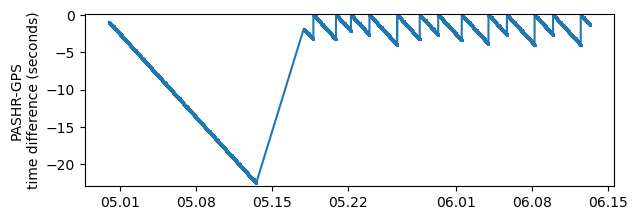

In [ ]:
# plot offsets between POSMV and its own GPS
pashr_gpsdt = timing_lidar.pashr_gps_datetime.(Pashr[:time], Pashr[:gpstime])
DVM = timing_lidar.DVM
pashr_gps_difference = DVM(Pashr[:time].-pashr_gpsdt) # value, ms
finesse_gps_difference = DVM(Pashr[:time].-Pashr[:posmvdt])

clf()
subplot(2,1,1)
plot(Pashr[:time][1:35:end], pashr_gps_difference[1:35:end]/1_000, marker=".", markersize=1 )#, linestyle="none") # slow
ylabel("PASHR-GPS\ntime difference (seconds)")
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m.%d"))
# xlim([DateTime(2024,5,17,0), DateTime(2024,6,16,0)])
ylim([-23, 0.2])
# gcf()
# has jitter, POSMV GPS set ahead of POSMV clock by ~+80 ms, sometimes ~+160 ms.
# leg 2, part 2 with lidar VectorNav data
# Pashr[:time][[findfirst(Pashr[:time].>Date(2024,5,17)), end]]

leg 1: GPS runs faster than POSMV (about 1.6 s/day), running ahead up to 22.58 s by end of leg 2. GPS is never adjusted or reset in leg 1.

leg 2: GPS drifts ahead of POSMV at same rate as leg 1 and then resets to an offset of POSMV-GPS = +80, +120, or +160 ms every 1.5-2.5 days.

Based on the positive offsets to which the GPS resets, the POSMV is probably running a little slow
so refine it by adding a tiny bit to speed up its adjusted clock.

In [18]:
# functions for building precise time coordinates and finding reference times
meandt = timing_lidar.meandt
MRi = timing_lidar.MRi

"extrapolate reference time"
# for ASTRAL leg 1, when there were no GPS updates
function extrap_t0(t, Δ, offset_slope)
    # t_mean = first(t) + MRi( mean( DVM.(t.-first(t)) ) )
    t_mean = meandt( t )
    Δ_mean = mean( Δ )
    t_mean - MRi( Δ_mean / offset_slope)
end

function build_dt_coord(tref::DateTime, dt::AbstractVector{DateTime}, dilate)
    @. tref + MRi( dilate * DVM(dt - tref) )
end

build_dt_coord (generic function with 1 method)

In [19]:
# compute reference time, and offset_slope of leg1

# limits of leg 1
startl1 = findfirst( Pashr[:time].<Date(2024,5,15) )
endl1 = findlast( Pashr[:time].<Date(2024,5,15) )
offset_slope = ( pashr_gps_difference[endl1] - pashr_gps_difference[startl1] ) / DVM( Pashr[:time][endl1] - Pashr[:time][startl1] )

# trust POSMV time at t0_l1; use for leg 1
t0_l1 = extrap_t0(Pashr[:time][startl1:endl1], pashr_gps_difference[startl1:endl1], offset_slope)

2024-04-29T10:38:41.759

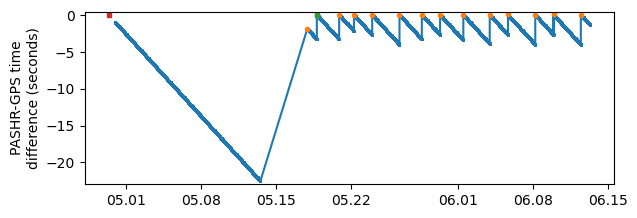

In [45]:
# fine tune POSMV time -> posmvdt

# add up GPS reset time decrements by hand gives about 1300 ms.
# startl2p2_ = findfirst(Pashr[:time].>Date(2024,5,17))
startl2p2_candidates = findall(Pashr[:time].>Date(2024,5,17) .&& [false; diff(pashr_gps_difference).>1_000])
startl2p2 = startl2p2_candidates[2]
tref = Pashr[:time][startl2p2]
pashr_gps_difference[startl2p2]

clf()
subplot(2,1,1)
plot(Pashr[:time][1:35:end], pashr_gps_difference[1:35:end]/1_000, marker=".", markersize=1 )#, linestyle="none") # slow
plot(Pashr[:time][startl2p2_candidates], pashr_gps_difference[startl2p2_candidates]/1_000, marker="o", markersize=3, linestyle="none" )
plot(Pashr[:time][startl2p2], pashr_gps_difference[startl2p2]/1_000, marker="s", markersize=3, linestyle="none" )
plot(t0_l1, 0, marker="s", markersize=3, linestyle="none" )
ylabel("PASHR-GPS time\ndifference (seconds)")
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m.%d"))
# xlim([DateTime(2024,5,17,0), DateTime(2024,6,16,0)])
ylim([-23, 0.5])
gcf()
# pashr_gps_difference[startl2p2] # +76 ms

# This is the POSMV clock compared to its own internal GPS time.

In [105]:
ll = startl2p2_candidates[1]:startl2p2_candidates[2]-1
t_offset = pashr_gpsdt[ll[1]] - Pashr[:time][ll[1]]
# t_offset = meandt(pashr_gpsdt[ll]) - meandt(Pashr[:time][ll])

1824 milliseconds

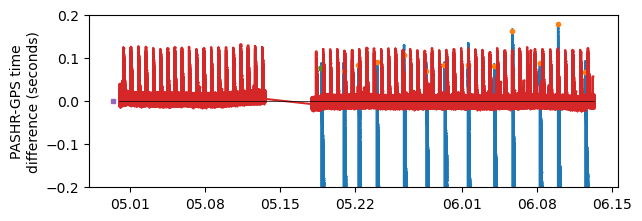

In [ ]:
# create posmvdt timestamp dilated and offset to agree with GPS

1300/DVM(diff(Pashr[:time][[startl2p2, end]]))[1]
# If GPS updates are to be believed,
# POSMV has a good clock that's about 5.7e-7:1 slow. 
# It loses about 1.3 second over the whole of leg2.
# Add this evenly to the clock time to speed it up.
# Agreeing within a second would be great.
# Leg 1 there is no GPS timing correction, so we don't know the offset.
# Assume, based on the GPS-POSMV time difference that
# the dilation of the POSMV clock is the same as in leg 2,
# and extrapolate the reference time above as t0_l1
# Leg 2 apparently is synced and agrees very well with the GPS.
dilate1 = 1 + 31.3*1300/DVM(diff(Pashr[:time][[startl2p2, end]]))[1]
dilate2 = 1 + 31.2*1300/DVM(diff(Pashr[:time][[startl2p2, end]]))[1]

# Posmv dilated datetime agrees with start of leg 2, part 2
# Leg 1 has no resets, but drift from the GPS clock looks the same, 
# so use same dilation factor as found from resets in leg 2.

# make leg 1 posmvdt with its own reference time
ll1 = 1:startl2p2_candidates[1]-1
posmvdt = build_dt_coord(t0_l1, Pashr[:time], dilate1) # allocate leg1 and leg2, but only good for leg 1
# now overwrite posmv for leg 2
ll2 = startl2p2_candidates[1]:length(posmvdt)
# adding in the POSMV clock correction to make it agree with the updated GPS
# posmvdt[ll2] = build_dt_coord(tref, Pashr[:time][ll2], dilate) .+ Millisecond(pashr_gps_difference[startl2p2]) # for leg 2

# build on segments of time coord after each GPS sync
ends = [startl2p2_candidates[2:end].-1; length(Pashr[:time])]
for i in eachindex(startl2p2_candidates)
    ll = startl2p2_candidates[i]:ends[i]
    t0 = Pashr[:time][ll[1]]
    posmvdt[ll] .= build_dt_coord(t0, Pashr[:time][ll], dilate2)
end

# fix first bit of leg2 which does not directly follow a GPS sync
ll = startl2p2_candidates[1]:startl2p2_candidates[2]-1
t_offset = pashr_gpsdt[ll[1]] - Pashr[:time][ll[1]]
posmvdt[ll] .+= t_offset

# ad hoc offset for other leg2 subinterval syncs
for i in eachindex(startl2p2_candidates)[2:end]
    ll = startl2p2_candidates[i]:ends[i]
    posmvdt[ll] .-= Millisecond(80)
end

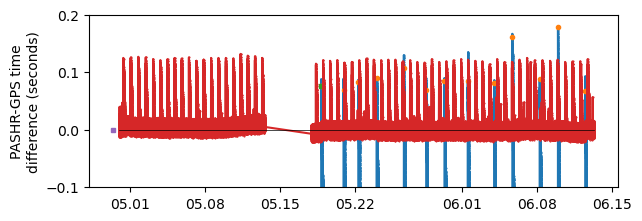

In [126]:
# plot PASHR[:time] and posmvdt minus GPS timestamp

finesse_gps_difference = DVM(posmvdt.-pashr_gpsdt)
finesse_difference = DVM(Pashr[:time].-posmvdt)

clf()
subplot(2,1,1)
plot(Pashr[:time][1:35:end], pashr_gps_difference[1:35:end]/1_000, marker=".", markersize=1 )#, linestyle="none") # slow
plot(Pashr[:time][startl2p2_candidates], pashr_gps_difference[startl2p2_candidates]/1_000, marker="o", markersize=3, linestyle="none" )
plot(Pashr[:time][startl2p2], pashr_gps_difference[startl2p2]/1_000, marker="s", markersize=3, linestyle="none" )
plot(Pashr[:time][1:35:end], finesse_gps_difference[1:35:end]/1_000, marker=".", markersize=1 )
plot(t0_l1, 0, marker="s", markersize=3, linestyle="none" )
plot(Pashr[:time][[1, end]], [0, 0], color="k", linewidth=0.5 )#, linestyle="none") # slow
ylabel("PASHR-GPS time\ndifference (seconds)")
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m.%d"))
# xlim([DateTime(2024,5,17,0), DateTime(2024,6,16,0)])
# ylim([-3.5, 0.3])
ylim([-0.1, 0.2])
# xlim([DateTime(2024,5,20,7,0,0), DateTime(2024,5,20,12,0,0)]) # jitter
gcf()
# posmvdt is a lovely time coordinate for the POSMV
# It is in UTC time, which is a constant 18 s behind 
# GPS conventional time, used by VectorNav.

In [127]:
# save posmvdt in the JLD2 file

Pashr[:posmvdt] = posmvdt # add finessed time axis to the Dict
save("./data/table/ASTraL_POSMV_v2.jld2", Dict(String(key) => value for (key, value) in Pashr))
# Pashr

In [128]:
median(diff(Vn[:GpsTime]))/1e6 / median(DVM(diff(posmvdt))) \ 1


10.000025600065536

With the adjustment suggested above for the POSMV, and that for the UND VectorNav, we should be able to interpolate and compare heave, pitch, and roll (heading is unfortunately bad) from both of these on a consistent time base.

Might use the ship survey to get moments from POSMV to lidar. (Should be able to estimate to nearest foot or so.)

In [129]:
# plot jitter and skipped timesteps
subplot(2,1,1)
minimum(DVM(Pashr[:time].-pashr_gpsdt)/1_000)
plot(DVM(diff(Pashr[:time])), marker=".", markersize=1, linestyle="none")
plot(DVM(diff(pashr_gpsdt)), marker=".", markersize=1, linestyle="none")
ylim([-100, 5000])
clf()

sum(DVM(diff(pashr_gpsdt)) .== 1000) # 11 exactly 1 s
DVM(diff(pashr_gpsdt))[DVM(diff(pashr_gpsdt)) .> 1000]
# 12 single skipped timesteps, 1 hiatus between legs
DVM(diff(Pashr[:time]))[DVM(diff(Pashr[:time])) .> 900]

26-element Vector{Int64}:
      1016
      1015
      1000
 378574746
      3818
      1000
      3819
      1000
      2696
      3227
         ⋮
      3955
       985
      4424
      3307
       985
      4571
      1000
      3311
      4543

GPS gets behind and then skips ahead. 
GPS clock is not that great (falls behind compared to POSMV), but gets
updated to agree with POSMV. POSMV timestamp is just fine. The GPS isn't good enough to correct it, 
but we do use the GPS increments (decrements actually) to fine tune the POSMV time axis. 

The GPS increments overshoot by 80 ms, etc., suggesting that the POSMV clock also runs slightly too slow.

## sync posmv pitch and vectornav "roll" by eye on brief subsets

In [130]:
# sync posmv and vectornav roll by hand on brief subsets

# synci0 = 1
df = dateformat"yyyy-mm-dd"
subsampl = 1
# post = findfirst( posmvdt .>= DateTime(2024,5,17,0,0,0) )
# vnst = findfirst( vndt    .>= DateTime(2024,5,17,0,0,0) )
# poen = findlast(  posmvdt .<= DateTime(2024,6,14,0,0,0) )
# vnen = findlast(  vndt    .<= DateTime(2024,6,14,0,0,0) )

# function daylimits(mon, day) # deprecated
#     post = findfirst( posmvdt .>= DateTime(2024,mon,day,6,0,0) )
#     vnst = findfirst( vndt    .>= DateTime(2024,mon,day,6,0,0) )
#     poen = findlast(  posmvdt .<= DateTime(2024,mon,day,7,0,0) )
#     vnen = findlast(  vndt    .<= DateTime(2024,mon,day,7,0,0) )
#     post, poen, vnst, vnen
# end

"posmv and vectornav indices for requested UTC DateTime start and epoch length TimePeriod"
function daylimits(utcdt::DateTime=DateTime(2024,6,1,6,0,0), epoch::Period=Minute(3))
    post = findfirst( posmvdt .>= utcdt )
    poen = findlast(  posmvdt .<= utcdt + epoch )
    vnst = findfirst( vndt    .>= utcdt + Second(18) ) # view +18 leapseconds forward to agree with UTC
    vnen = findlast(  vndt    .<= utcdt + Second(18) + epoch )
    post, poen, vnst, vnen
end

daylimits

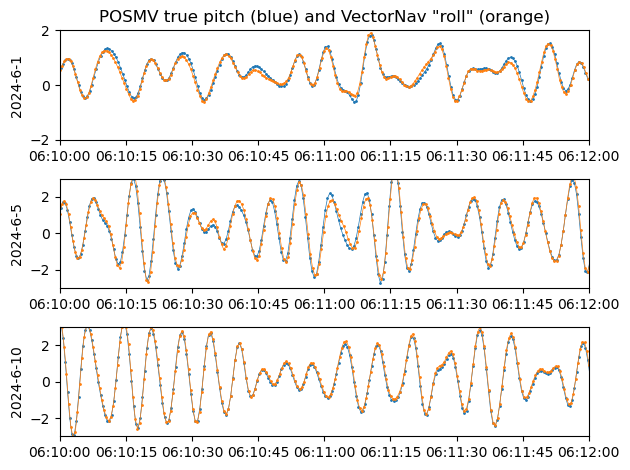

In [ ]:
subsampl = 1
vndt = Vn[:vndt]

clf()
post, poen, vnst, vnen = daylimits(DateTime(2024,6,1,6,10,0), Minute(3)) # June 1 1st day of Vn2
subplot(3,1,1)
plot(posmvdt[post:subsampl:poen], Pashr[:pitch][post:subsampl:poen].-0.3, label="POSMV", marker=".", markersize=2, linewidth=0.5)
plot(vndt[vnst:(10*subsampl):vnen]-Millisecond(18_000), Vn[:Roll][vnst:(10*subsampl):vnen].-0.43, label="VectorNav", marker=".", markersize=2, linewidth=0.5)
xlim([DateTime(2024,6,1,6,10,0), DateTime(2024,6,1,6,12,0)])
ylim([-2, 2])
title("POSMV true pitch (blue) and VectorNav \"roll\" (orange)")
ylabel("2024-6-1")

post, poen, vnst, vnen = daylimits(DateTime(2024,6,5,6,10,0))
subplot(3,1,2)
plot(posmvdt[post:subsampl:poen], Pashr[:pitch][post:subsampl:poen].-0.2, label="POSMV", marker=".", markersize=2, linewidth=0.5)
# plot(vndt[vnst:(10*subsampl):vnen]-Millisecond(round(Int64,17400+6.5/9*2600)), Vn[:Roll][vnst:(10*subsampl):vnen].+0.6, label="VectorNav", marker=".", markersize=2, linewidth=0.5)
plot(vndt[vnst:(10*subsampl):vnen]-Millisecond(18_000), Vn[:Roll][vnst:(10*subsampl):vnen].+0.6, label="VectorNav", marker=".", markersize=2, linewidth=0.5)
xlim([DateTime(2024,6,5,6,10,0), DateTime(2024,6,5,6,12,0)])
ylim([-3, 3])
ylabel("2024-6-5")
tight_layout()
gcf()

post, poen, vnst, vnen = daylimits(DateTime(2024,6,10,6,10,0)) # June 10 last day
subplot(3,1,3)
plot(posmvdt[post:subsampl:poen], Pashr[:pitch][post:subsampl:poen].-0.2, label="POSMV", marker=".", markersize=2, linewidth=0.5)
plot(vndt[vnst:(10*subsampl):vnen]-Millisecond(18_000), Vn[:Roll][vnst:(10*subsampl):vnen].-0.35, label="VectorNav", marker=".", markersize=2, linewidth=0.5)
xlim([DateTime(2024,6,10,6,10,0), DateTime(2024,6,10,6,12,0)])
ylim([-3, 3])
ylabel("2024-6-10")
tight_layout()
gcf()

# AGREES with a ~18 s offset.
# Matches amplitude modulation on a longer time envelope, 
# and with specific local offsets matches the phase extremely well. 
# VectorNav time ahead by ~18 s relative to POSMV. 

# POSMV native time and GPS time are reported in UTC. VectorNav time is in GPS time.
# By convention GPS time is +18 s ahead of UTC in May-June 2024. 

# Remaining time offsets are less than 0.5 s.

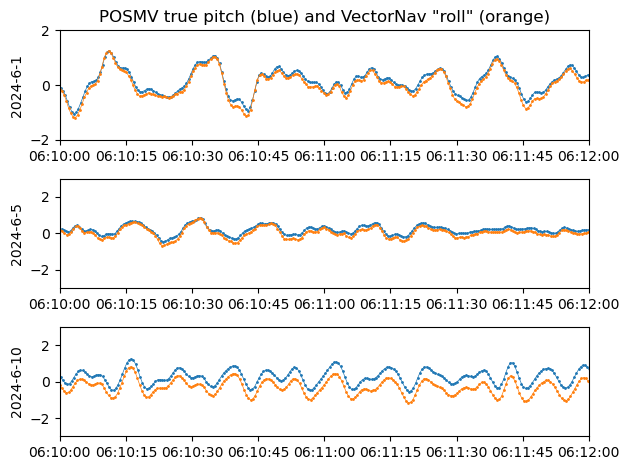

In [ ]:
subsampl = 1
vndt = Vn[:vndt]

clf()
post, poen, vnst, vnen = daylimits(DateTime(2024,5,10,6,10,0), Minute(3)) # June 1 1st day of Vn2
subplot(3,1,1)
plot(posmvdt[post:subsampl:poen], Pashr[:pitch][post:subsampl:poen], label="POSMV", marker=".", markersize=2, linewidth=0.5)
plot(vndt[vnst:(10*subsampl):vnen]-Millisecond(18_000), 0.5.+Vn[:Roll][vnst:(10*subsampl):vnen], label="VectorNav", marker=".", markersize=2, linewidth=0.5)
xlim([DateTime(2024,5,10,6,10,0), DateTime(2024,5,10,6,12,0)])
ylim([-2, 2])
title("POSMV true pitch (blue) and VectorNav \"roll\" (orange)")
ylabel("2024-6-1")

post, poen, vnst, vnen = daylimits(DateTime(2024,5,11,6,10,0))
subplot(3,1,2)
plot(posmvdt[post:subsampl:poen], Pashr[:pitch][post:subsampl:poen], label="POSMV", marker=".", markersize=2, linewidth=0.5)
# plot(vndt[vnst:(10*subsampl):vnen]-Millisecond(round(Int64,17400+6.5/9*2600)), Vn[:Roll][vnst:(10*subsampl):vnen].+0.6, label="VectorNav", marker=".", markersize=2, linewidth=0.5)
plot(vndt[vnst:(10*subsampl):vnen]-Millisecond(18_000), 0.5.+Vn[:Roll][vnst:(10*subsampl):vnen], label="VectorNav", marker=".", markersize=2, linewidth=0.5)
xlim([DateTime(2024,5,11,6,10,0), DateTime(2024,5,11,6,12,0)])
ylim([-3, 3])
ylabel("2024-6-5")
tight_layout()
gcf()

post, poen, vnst, vnen = daylimits(DateTime(2024,5,12,6,10,0)) # June 10 last day
subplot(3,1,3)
plot(posmvdt[post:subsampl:poen], Pashr[:pitch][post:subsampl:poen], label="POSMV", marker=".", markersize=2, linewidth=0.5)
plot(vndt[vnst:(10*subsampl):vnen]-Millisecond(18_000), 0.5.+Vn[:Roll][vnst:(10*subsampl):vnen], label="VectorNav", marker=".", markersize=2, linewidth=0.5)
xlim([DateTime(2024,5,12,6,10,0), DateTime(2024,5,12,6,12,0)])
ylim([-3, 3])
ylabel("2024-6-10")
tight_layout()
gcf()

# By convention GPS time is +18 s ahead of UTC in May-June 2024. 
# POSMV is reporting UTC, while VectorNav is reporting GPS. That explains it.

# 

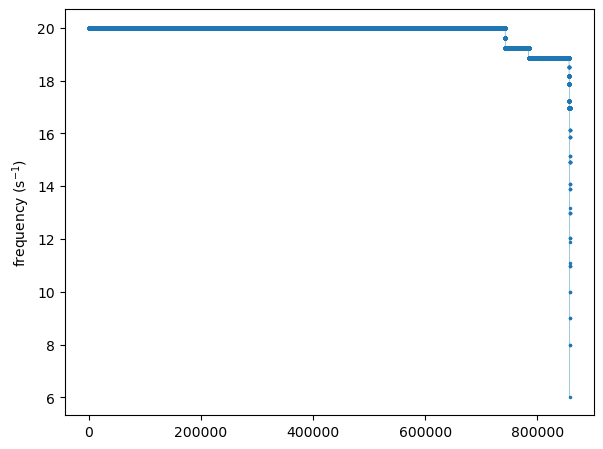

In [ ]:
clf()
plot(1_000 ./sort(DVM(diff(vndt)))[1:50:end], marker=".", markersize=3, linewidth=.3)
ylabel("frequency (s\$^{-1}\$)")
gcf()

# 20 Hz with a few delayed (or dropped) samples 

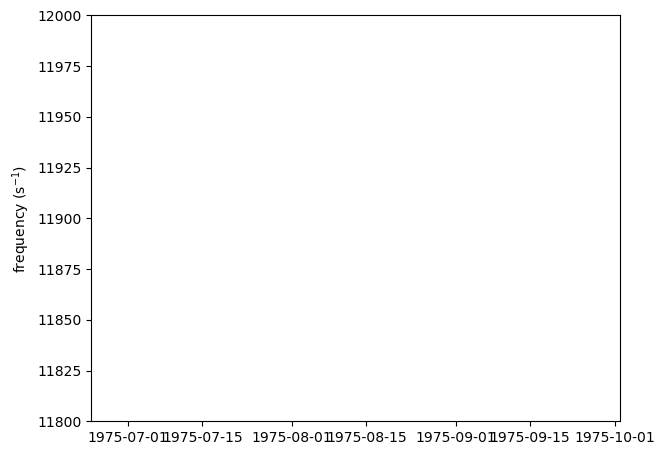

In [34]:
# count number of observations per 10 min block
discrtime = floor.(vndt, Minute(10))
ut = sort(unique(discrtime))
ct = zeros(Int64, size(ut)) 
i=1
for dt in discrtime
    if dt == ut[i]
        ct[i] += 1
    elseif dt > ut[i]
        i+=1
    end
end
# 5s

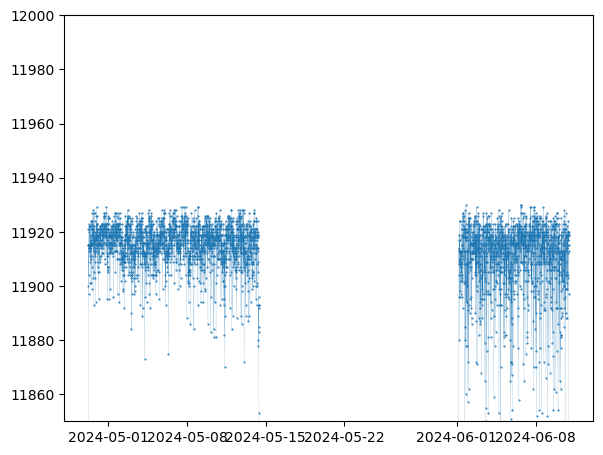

In [41]:
clf()
plot(ut, ct, marker=".", markersize=1, linewidth=0.1)
ylim(10*60*20 .+ [-150, 0])
gcf()

In [43]:
# mode sample rate is about
 1 - 11920/12000  # 0.667%
 1 - 11920//12000 # 1/150

1//150

In [71]:
# functions to find the lag to maximize the autocorrelation between two time series # MOVED to timing_lidar
#=
# e.g. the POSMV and VectorNav time series
# where VectorNav is factor=10 times the sampling rate of the POSMV. 
# Should also support factor=1.

# StatsBase.crosscor method for finding the optimal lag
# when time series are at same sampling rate.
"lag that maximizes the cross correlation"
function lag_xcor(x, y) 
    z = StatsBase.crosscor(x, y)
    delay=argmax(z)
    return lag = delay - div((size(z,1)+1),2) # lag=0 is in the center
end

"Cross-correlation function"
# use StateBase.crosscor
# could use DSP's trickier crosscor(x,y,lags), maybe faster using FFTs
function cross_correlation(lag, high_freq_series, low_freq_series, factor, start_idx, epoch_length)
    # start_idx is a low frequency index for the start of the epoch
    "index the epoch as a low frequency view"
    epx(lf) = lf[start_idx .+ (0:epoch_length-1)]
    # epx(lf) = lf[start_idx : min(start_idx+epoch_length-1, length(lf))] # ensure right in bounds

    # downsample and subset views
    if lag >= 0 # nonnegative lag
        # lag and downsample the high freq series
        x = epx( high_freq_series[round(Integer,lag+1):factor:end] )
        y = epx( low_freq_series )
    else # negative lag: indices need to be shifted in bounds
        # inbounds indices are >=1;
        # neg lag shifts both high and low freq series
        high_freq_offset = factor + lag%factor
        hfi = round(Integer, high_freq_offset%factor + 1)
        x = epx( high_freq_series[hfi:factor:end] ) # this line errors out of bounds!
        # positive offset for start of y
        low_freq_offset = round( Integer, -floor(lag / factor) )
        lfi = round(Integer, low_freq_offset + 1)
        y = epx( low_freq_series[lfi:end] ) # neg lag also shifts y
        # maxlen = max(length(y0), length(x0))
        # x = x0[1:maxlen] # shorten arrays if necessary
        # y = y0[1:maxlen]
    end
    cor(x, y) # StatsBase
end

"find the lag that maximizes the cross-correlation"
function find_optimal_lag(f, a, b) # a and b are left and right bounds
    result = Optim.optimize(x -> -f(x), a, b, Optim.Brent()) # optim for max correlation
    # result = Optim.optimize(x -> -f(x), a, b, Optim.GoldenSection()) # either Brent or GoldenSection works
    return Optim.minimizer(result) # returns the argument of minimum of f
end


function grid_search(high_freq_series, low_freq_series, factor, start_idx, epoch_length, initial_guess, window=40)   
    # find lag of max correlation with method from Optim, or brute force argmax
    crosscor_f(lag) = cross_correlation(lag, high_freq_series, low_freq_series, factor, start_idx, epoch_length)
    # find max correlation by brute force
    bruteforce_optimal_lag( lags::AbstractVector ) = lags[ argmax(crosscor_f.(lags)) ]
    "index the epoch from/as a low frequency view"
    # epx(lf) = lf[start_idx .+ (0:epoch_length-1)]
    eplen(lf) = min(epoch_length, length(lf)-start_idx+1) # emulates length of epx() windows
    
    # Initialize variables for the best lag and correlation
    left = initial_guess - window
    right = initial_guess + window
    # (inbounding was handed within cross_correlation)
    
    # check lagged (downsampled) views are in bounds
    nx = epoch_length
    ny = epoch_length
    for lag = [left, right]
        if lag >= 0 # nonnegative lag
            # lag and downsample the high freq series
            nx = min(nx, eplen( round(Integer,lag+1):factor:length(high_freq_series) ))
            ny = min(ny, eplen( 1:length(low_freq_series) ))
        else # negative lag: indices need to be shifted in bounds
            # inbounds indices are >=1;
            # neg lag shifts both high and low freq series
            high_freq_offset = factor + lag%factor
            hfi = round(Integer, high_freq_offset%factor + 1)
            # hfi(lag, factor=factor) = round(Integer, start_idx + (lag%factor + factor)%factor)  #nope not in one step
            nx = min(nx, eplen( hfi:factor:length(high_freq_series) )) # this line errors out of bounds!
            # positive offset for start of y
            low_freq_offset = round( Integer, -floor(lag / factor) )
            lfi = round(Integer, low_freq_offset + 1)
            ny = min(ny, eplen( lfi:length(low_freq_series) )) # neg lag also shifts y
        end
    end

    # condition on being inbounds
    if nx==ny==epoch_length # there is data to fill the epoch
        # optimal_lag = find_optimal_lag(crosscor_f, left, right) # doesn't work well
        optimal_lag = bruteforce_optimal_lag(left:right)
    elseif min(nx,ny) < epoch_length # epoch window out of range
        optimal_lag = missing
    end
    return optimal_lag #, best_cor
end

"""
Find the lag for local epochs
"""
function find_lags_iterative(high_freq_series, low_freq_series, factor, start_idxs, epoch_length, initial_guess; window=40)
    # optimal_lags = missing .+ zeros(Union{Missing, Int64}, size(start_idxs))
    optimal_lags = Vector{Union{Missing, Int64}}(missing, size(start_idxs))
    
    ic = 0
    for start_idx in start_idxs # loop each epoch
        if start_idx < length(low_freq_series) - epoch_length
            ic += 1
            optlag = grid_search(high_freq_series, low_freq_series, factor, start_idx, epoch_length, initial_guess, window)
            # Use the optimal lag from the current epoch as the 
            # initial guess for the next epoch

            if !ismissing(optlag)
                initial_guess = optlag
                optimal_lags[ic] = round(Int64, optlag)
            end
        end
    end
    
    return optimal_lags[1:ic]
end
=#

find_lags_iterative

In [51]:
# calculate time offsets between VectorNav and POSMV

post, poen, vnst, vnen = daylimits(DateTime(2024,6,1,6,0,0), Minute(3))
posmvdt[[post, poen]], vndt[[vnst, vnen]]

# rather than index.
factor = 10        # hi/lo sample rate
epoch_length = 480 # lo-freq samples, 4 min windows
initial_guess = 0
window = 90
wideoffset = 4 # s
start_idx = 2*wideoffset # corresp to ±4 s possible offsets 

# calvulate lag every 10 min
dts = (DateTime(2024,6,1,6,0,)-Second(wideoffset)):Minute(10):(DateTime(2024,6,5,6,0,0)+Second(wideoffset))

optlag = zeros(Int32, length(dts))
for (i, dt) in enumerate(dts)
    (post, poen, vnst, vnen) = daylimits(dt, Minute(5)) # 5 m window epoch
    low_freq_series = Pashr[:pitch][post:poen]
    high_freq_series = Vn[:Roll][vnst:vnen]
    initial_guess = grid_search(high_freq_series, low_freq_series, factor, start_idx, epoch_length, initial_guess, window)
    optlag[i] = initial_guess
end


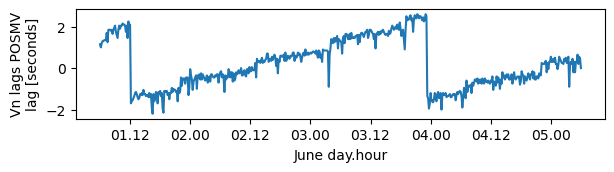

In [49]:
clf()
subplot(3,1,1)
plot(dts, 0.05*optlag)
ylabel("Vn lags POSMV\nlag [seconds]")
# ylim([-30, 2])
xlabel("June day.hour")
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d.%H"))
gcf()

# SIGNS
# +Positive lag means Vn start index is shifted forward.
# Data in this shifted index is (moved backward and) aligned with the unshifted POSMV start. 
# i.e., Vn signal lags POSMV.
#
# -Negative lag means negative index of Vn lines up with start of POSMV epoch,
# i.e., Vn signal leads POSMV.

Now with these optimal lags, estimate the moments for solid body rotation from the POSMV to the lidar.

In [56]:
Pashr
# hex2uint(dd) = parse(UInt8, dd, base = 16)
# hex2uint.(Pashr[:checksum])

Dict{Symbol, Vector} with 13 entries:
  :ins_Status_flag         => UInt8[0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0…
  :heading                 => Float32[204.8, 204.74, 204.68, 204.65, 204.64, 20…
  :checksum                => ["3A", "30", "39", "1B", "3C", "34", "34", "3C", …
  :time                    => [DateTime("2024-04-30T00:00:01.840"), DateTime("2…
  :pitch_accuracy          => Float32[0.022, 0.022, 0.022, 0.022, 0.022, 0.022,…
  :heading_accuracy        => Float32[0.016, 0.016, 0.016, 0.016, 0.016, 0.016,…
  :trueheading             => Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1,…
  :heave                   => Float32[0.26, 0.15, 0.04, -0.08, -0.21, -0.35, -0…
  :gpstime                 => Time[00:00:02.729, 00:00:03.229, 00:00:03.729, 00…
  :roll                    => Float32[-1.29, -1.52, -1.7, -1.83, -1.91, -1.9, -…
  :pitch                   => Float32[0.58, 0.51, 0.36, 0.14, -0.12, -0.4, -0.6…
  :roll_accuracy           => Float32[0.022, 0.022, 0.022, 0.022, 0.022

In [65]:
Vn

Dict{Symbol, Vector} with 22 entries:
  :LinAcc1  => Float32[0.28455, -0.563547, 0.545289, -0.615101, 0.663306, -0.17…
  :Roll     => Float32[-0.684141, -0.711255, -0.714359, -0.761043, -0.767432, -…
  :Latitude => Float32[16.2633, 16.2633, 16.2633, 16.2633, 16.2633, 16.2633, 16…
  :vndt     => [DateTime("2024-04-29T05:25:42.128"), DateTime("2024-04-29T05:25…
  :time     => [DateTime("2023-03-29T13:17:44"), DateTime("2023-03-29T13:17:44"…
  :Yaw      => Float32[-162.59, -162.574, -162.565, -162.549, -162.541, -162.53…
  :VelNED1  => Float32[5.05222, 5.04132, 5.05353, 5.04639, 4.93381, 4.93558, 4.…
  :MagNED2  => Float32[0.09548, 0.100129, 0.09543, 0.095481, 0.093838, 0.09533,…
  :Altitude => Float32[-43.986, -43.986, -43.986, -43.986, -44.212, -44.212, -4…
  :Quat1    => Float32[0.005692, 0.005927, 0.005941, 0.006337, 0.006396, 0.0065…
  :VelNED2  => Float32[-0.280547, -0.279673, -0.27213, -0.271012, -0.272294, -0…
  :MagNED0  => Float32[0.234275, 0.237392, 0.23345, 0.236116, 0.233466,

In [47]:
#= find_lag_iterative iterates by index, --deprecated--
# The indexed skip true times.

function daylimits(mon=6, day=1)
    post = findfirst( posmvdt .>= DateTime(2024,mon,day,0,2,0) )
    vnst = findfirst( vndt    .>= DateTime(2024,mon,day,0,2,18) ) # view +18 leapseconds forward to agree with UTC
    poen = findlast(  posmvdt .<= DateTime(2024,6,10,23,24,0) )
    vnen = findlast(  vndt    .<= DateTime(2024,6,10,23,24,18) )
    post, poen, vnst, vnen
end
post, poen, vnst, vnen = daylimits(DateTime(2024,6,1,6,0,0), Day(1)) # June 1 1st day of Vn2
# clf()
# subplot(3,1,1)
# plot(posmvdt[post:subsampl:poen], Pashr[:pitch][post:subsampl:poen].-0.3, label="POSMV", marker=".", markersize=2, linewidth=0.5)
# plot(vndt[vnst:(10*subsampl):vnen]-Millisecond(20000), Vn[:Roll][vnst:(10*subsampl):vnen].-0.43, label="VectorNav", marker=".", markersize=2, linewidth=0.5)
# xlim([DateTime(2024,6,1,6,10,0), DateTime(2024,6,1,6,12,0)])

# Brent() works faster and better than GoldenSection() for this.
# but still not very well.

factor = 10
start_idxs = 1:1200:(poen-post+1) # every 10 min # for low-freq posmv
# start_idxs = post : 2400 : poen # for low-freq posmv, sample every 20 min
epoch_length = 360 # lo-freq samples
initial_guess = 0 # hi-freq samples
low_freq_series = Pashr[:pitch][post:poen]
high_freq_series = Vn[:Roll][vnst:vnen]

optlag = find_lags_iterative(high_freq_series, low_freq_series, factor, start_idxs, epoch_length, initial_guess; window=600)
# takes 40 s for 10 days of 2-min epochs. 2 min for 3 min epochs
# takes 30 s for 3 min windows every 10 min for 1 day

# optlag drifts 10 min negative in 1 day!
=#

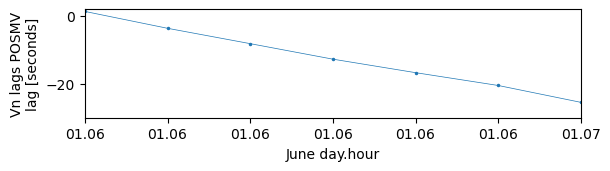

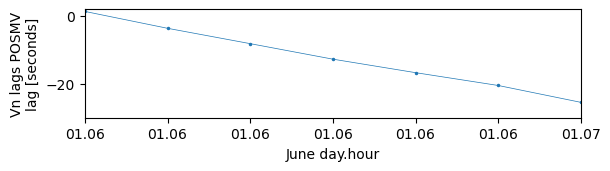

In [104]:
clf()
subplot(3,1,1)
plot(posmvdt[post:poen][start_idxs], 0.049653 .* m2n.(optlag), marker=".", markersize=3, linewidth=0.5) # seconds
ylabel("Vn lags POSMV\nlag [seconds]")
ylim([-30, 2])
xlabel("June day.hour")
xlim([DateTime(2024,6,1,6), DateTime(2024,6,1,7)])
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d.%H"))
gcf()
# linear
# a negative lag of the Vn means it's shifted forward

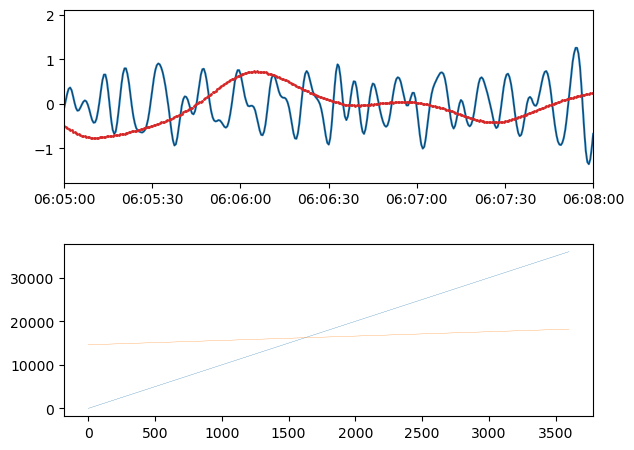

In [117]:
# try using SignalAlignment package
using SignalAlignment

# parameters
master = Shortest() # Index(1) # low-rate POSMV
# method = Warp(warp_method=DTW(radius=10)) # fun but weird
method = Delay(delay_method = DTWDelay()) # XcorrDelay() more traditional
output = Indices()

# time view
post, poen, vnst, vnen = daylimits(DateTime(2024,6,1,6,0,0), Minute(30)) # VevtorNav only turned on between 04-05h UTC
x = anom(Pashr[:pitch][post:poen]) # [post.+(0:epoch_length-1)]
y = anom(Vn[:Roll][vnst:vnen]) # [vnst.+(0:factor*epoch_length-1)]  # fast
signals = [ x, y ]
align_index = align_signals(signals, method; master, output)

clf()
subplot(2,1,1)
plot(posmvdt[post:poen], signals[1])
plot(posmvdt[post:poen][align_index[1]], signals[1][align_index[1]], linewidth=0.25, color="k")
# plot(vndt[vnst:vnen]-Second(18), signals[2])
# plot(vndt[vnst:vnen][align_index[2]]-Second(18), signals[2][align_index[2]], color="tab:green", marker=".", markersize=2, linewidth=0.5)
plot(posmvdt[post:poen][align_index[1]], signals[2][align_index[2]], linewidth=0.25, marker=".", markersize=2, color="tab:red")

xlim([DateTime(2024,6,1,6,5,0), DateTime(2024,6,1,6,8,0)])
# plot(posmvdt[post.+(0:epoch_length-1)], signals[1])
# plot(posmvdt[post.+(0:epoch_length-1)][align_index[1]], signals[1][align_index[1]], linewidth=0.25, color="w")
# plot(vndt[vnst.+(0:factor*epoch_length-1)]-Second(18), signals[2])
# plot(vndt[vnst.+(0:factor*epoch_length-1)][align_index[2]]-Second(18), signals[2][align_index[2]], color="tab:green", marker=".", linewidth=0.5)
# plot(posmvdt[post.+(0:epoch_length-1)][align_index[1]], signals[2][align_index[2]], color="r")

subplot(2,1,2)
plot(10*align_index[1], linewidth=.2) #, marker=".", markersize=2, linestyle="none")
plot(   align_index[2], linewidth=.2) #, marker=".", markersize=2, linestyle="none")

median((align_index[2] .- 1) .- 10 * (align_index[1] .- 1)) = -108.0


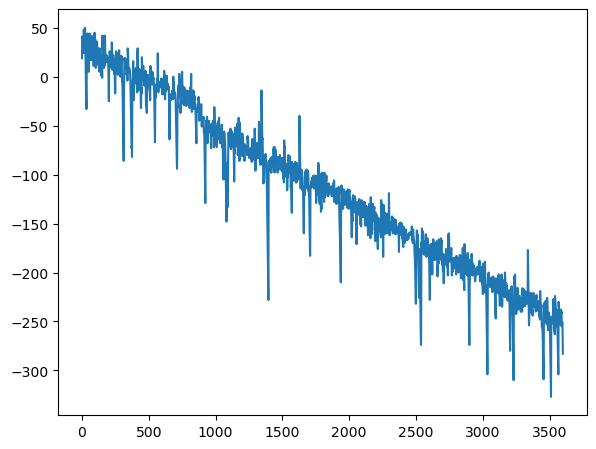

In [86]:
clf()
plot(align_index[2] - 10*align_index[1])
@show median( align_index[2].-1 .- 10*(align_index[1].-1) )
gcf()

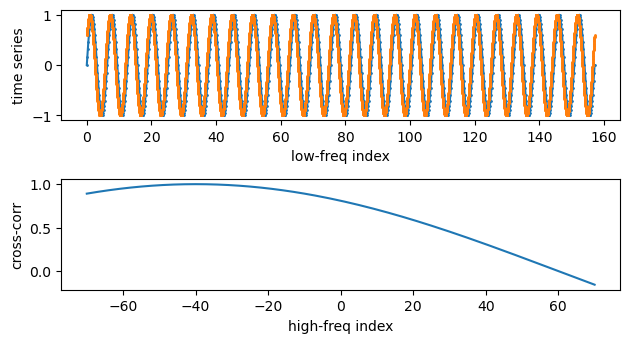

4-element Vector{Union{Missing, Int64}}:
 -40
 -40
 -40
 -40

In [96]:
# Example usage and test
hft = pi/2*(0:0.01:100)
lft = pi/2*(0:0.1:100)
targetlag = -40
high_freq_series = sin.(hft .- pi/2*0.01*targetlag)  # Replace with high-frequency series
low_freq_series  = sin.(lft)  # Replace with low-frequency series

subplot(3,1,1)
plot(lft, low_freq_series, marker=".", markersize=2)
plot(hft, high_freq_series, marker=".", markersize=2, linewidth=0.1) # orange
ylabel("time series")
xlabel("low-freq index")
factor = 10                         # Replace with the ratio of the sampling rates
epoch_length = 240  # 2 min         # Define the length of each epoch in low-freq samples
start_idxs = 1:240:length(lft)-239
initial_guess = -9 # lag

# check and plot cross_correlation
start_idx = 100 # insensitive to start_idx
crosscor_f(lag) = cross_correlation(lag, high_freq_series, low_freq_series, factor, start_idx, epoch_length)
xc = crosscor_f.(-70:70)
subplot(3,1,2)
# plot(-70:70, xc)
plotf(crosscor_f, -70:70)
ylabel("cross-corr")
xlabel("high-freq index")
# cross-correlation is correct
tight_layout()

optimal_lags = find_lags_iterative(high_freq_series, low_freq_series, factor, start_idxs, epoch_length, initial_guess)
# there can be an aliasing problem.
# bisection is not stable.
# grid_search works for negative and positive lags.

In [251]:
# test grid search for sensitivity to lag, positive and negative
start_idx=12 # insensitive to start_idx
initial_guess = 20 # must be sort of close
grid_search(high_freq_series, low_freq_series, factor, start_idx, epoch_length, initial_guess)

40.464112299554145

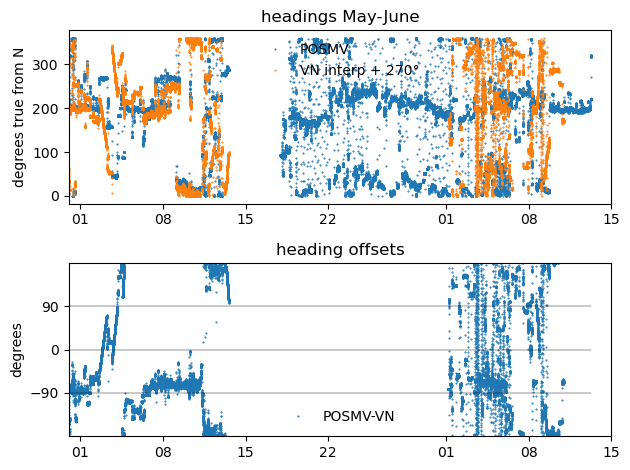

In [116]:
# plots compare UND VectorNav to POSMV ship heading <-- Vn heading is not good
i0 = 1
df = dateformat"yyyy-mm-dd"
subsampl = 120
uwrap(t) = ((t+180) % 360) - 180

clf()
subplot(2,1,1)
plot(Pashr[:time][1:subsampl:end], Pashr[:heading][1:subsampl:end], label="POSMV", marker=".", markersize=1, linestyle="none")
# plot(gps2dt.(Vn[:GpsTime][i0:subsampl0:end]), (Vn[:Yaw][i0:subsampl0:end].+270.0).%360, label="VN + 270°", marker=".", markersize=1, linestyle="none")
plot(Pashr[:time][1:subsampl:end], (vn_yaw_dt[1:subsampl:end].+270) .% 360, label="VN interp + 270°", marker=".", markersize=1, linestyle="none")
xlim(Date(Pashr[:time][1]).+Day.([0, 46]))
legend(frameon=false)
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d"))
# title("headings $(Dates.format(Pashr[:time][1],df))")
title("headings May-June")
ylabel("degrees true from N")

subplot(2,1,2)
plot(Pashr[:time][1:subsampl:end], uwrap.(Pashr[:heading].-vn_yaw_dt)[1:subsampl:end], label="POSMV-VN", marker=".", markersize=1, linestyle="none")
plot(Pashr[:time][[1, end]], [-90, -90], color="k", linewidth=0.3)
plot(Pashr[:time][[1, end]], [0, 0], color="k", linewidth=0.3)
plot(Pashr[:time][[1, end]], [90, 90], color="k", linewidth=0.3)
xlim(Date(Pashr[:time][1]).+Day.([0, 46]))
legend(frameon=false)
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d"))
yticks(-90:90:90)
title("heading offsets")
ylabel("degrees")
ylim([-180, 180])

tight_layout()


At first, the UND lidar table VectorNav is pointed about 90° to the right (to startboard) of the ship's coordinate system, resulting in VectorNav heading mostly +90° greater than the ship's true heading. The GPS solution seems to depend on the heading itself.

The mean alignment shifts so that the VN points forward of starboard May 2.
It completes nearly a full turn from its initial positon May 5.


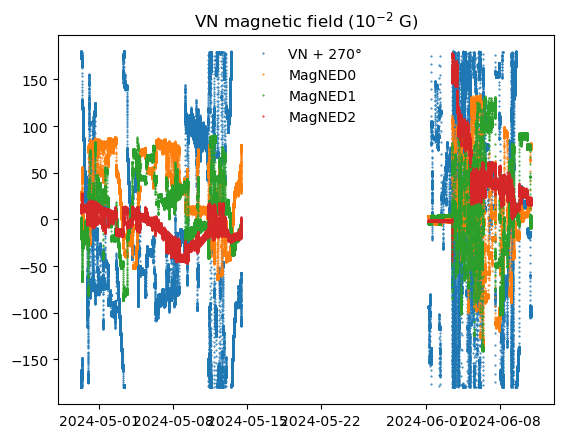

PyObject <matplotlib.legend.Legend object at 0x931401810>

In [124]:

# magnetometer (gauss)
plot(gps2dt.(Vn[:GpsTime][i0:subsampl:end]), (Vn[:Yaw][i0:subsampl:end]), label="VN heading", marker=".", markersize=1, linestyle="none")
plot(gps2dt.(Vn[:GpsTime][i0:subsampl:end]), 100*(Vn[:MagNED0][i0:subsampl:end]), label="MagNED0", marker=".", markersize=1, linestyle="none")
plot(gps2dt.(Vn[:GpsTime][i0:subsampl:end]), 100*(Vn[:MagNED1][i0:subsampl:end]), label="MagNED1", marker=".", markersize=1, linestyle="none")
plot(gps2dt.(Vn[:GpsTime][i0:subsampl:end]), 100*(Vn[:MagNED2][i0:subsampl:end]), label="MagNED2", marker=".", markersize=1, linestyle="none")
title("VN magnetic field (10\$^{-2}\$ G)")
ylim([-180, 180])
legend(frameon=false)

In [22]:
bigread = false

if bigread
    # precompile reader on a short file
    datadir = joinpath(homedir(), "Data/EKAMSAT/lidar/table")
    file = joinpath(datadir, "VNshort.txt") #"VectorNavTableData.txt")
    @time test = read_vecnav_dict( file ) 
    @time test = read_vecnav_dict( file ) 

    # process the big read Vn data
    @time Vn = read_vecnav_dict( file ) # very big slow read takes 2:27; !compile first!
    # study time index
    plot(Vn[:GpsTime][1200:1200:end], marker=".", linestyle="none") # jumps
    plot(Vn[:time][1200:1200:end], marker=".", linestyle="none") # monotonic
    i0 = findfirst(diff(Vn[:GpsTime][:]) .> 1e17) + 1
    # i0=663 # first good index of big Vn structure

    # diff(Vn[:GpsTime][700:712]) # integer nanoseconds = 10-9 s
    # 50_000_000 ns is 0.05 s


    # gps2dt(gpstime::Vector) = gps2dt.(gpstime)

    # fix the time
    delete!(Vn, :time)
    Vn[:time] = gps2dt.(Vn[:GpsTime]) # re-add

    # # time interpolator, truncates
    # itp_vn(k, t) = interpolate(Dates.value.(Vn[:time][i0:end]), Vn[k][i0:end])[t]

    # write in a big mat file - no offsets
    matopen("VectorNavTable.mat", "w") do matfile
        # Write the variables to the MAT file
        write(matfile, "time_offset", Dates.value.(Vn[:time][i0:end] .- Vn[:time][i0])) # millisec since base_time
        write(matfile, "base_time",  Dates.format( Vn[:time][i0], "yyyy-mm-dd HH:MM:SS.sss" ))
        for k in filter(k -> k !== :time, keys(Vn)) # write the rest of the variables
            write(matfile, String(k), Vn[k][i0:end])
        end
        close(matfile)
    end

    # write 1 JLD2 file - no offsets
    jldopen("VectorNavTable.jld2", "w") do file
        # Write the VectorNav dict to the JLD2 file
        # no time offsets
        file["Vn"] = Vn
    end

    # read 1 big JLD2 file 
    jldopen("VectorNavTable.jld2", "r") do file # subsetting while reading saves no time
        vn_dt = file["Vn"][:time]
        pitch = file["Vn"][:Pitch]   # degrees 
        roll  = file["Vn"][:Roll]    # degrees
        heave = file["Vn"][:VelNED2] # m/s
    end

    # save smaller subsets as daily files for easier reading
    days = unique(Date.(Vn[:time][i0:end]))

    for d in days
        # st = maximum(i0, findfirst(t -> t >= d, vn_dt ))
        st = findfirst(t -> t >= d       , Vn[:time] ) # no offsets
        en = findlast( t -> t <  d+Day(1), Vn[:time] )
        yyyymmdd = Dates.format(d, dateformat"yyyymmdd")

        jldopen(joinpath(datadir, "VectorNavTable_$(yyyymmdd).jld2"), "w") do file
            # Write the VectorNav dict to the JLD2 file
            file["time"]  = Vn[:time ][st:en]
            file["pitch"] = Vn[:Pitch][st:en]
            file["roll"]  = Vn[:Roll ][st:en]
            file["heave"] = Vn[:VelNED2][st:en]
        end
    end

end

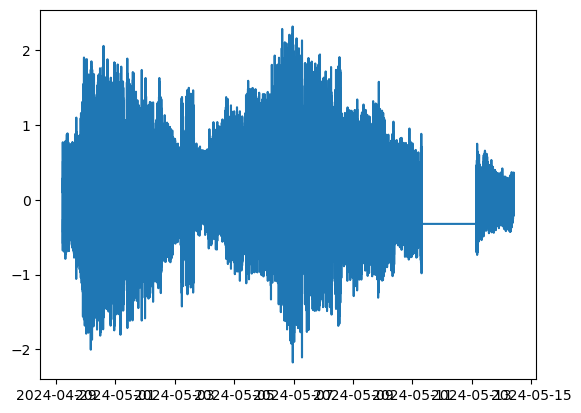

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7d0855750>

In [10]:
# read whole big JLD2 file, look at heave
file = jldopen("VectorNavTable.jld2", "r") # subsetting while reading saves no time
    vn_dt = file["Vn"][:time]
    pitch = file["Vn"][:Pitch]   # degrees 
    roll  = file["Vn"][:Roll]    # degrees
    heave = file["Vn"][:VelNED2] # m/s
close(file)

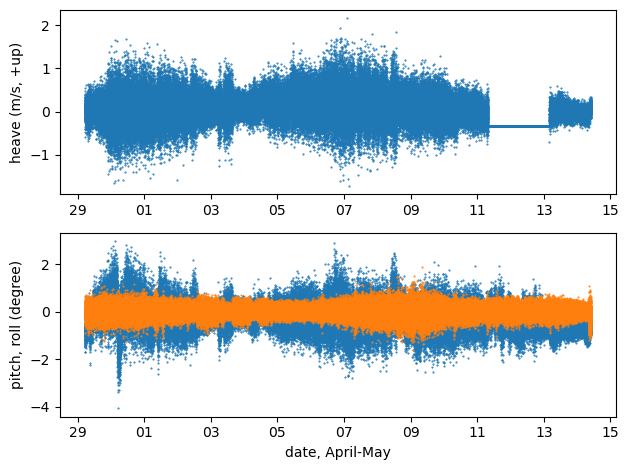

In [19]:
ii = vn_dt .> Date(2000,1,1)
date_formatter = PyPlot.matplotlib.dates.DateFormatter("%d") # "%Y-%m-%d"

subplot(2,1,1)
plot(vn_dt[ii][1:200:end], -heave[ii][1:200:end], linestyle="none", marker=".", markersize=1) # -> up positive
ax=gca()
ax[:xaxis][:set_major_formatter](date_formatter)
ylabel("heave (m/s, +up)")

subplot(2,1,2)
plot(vn_dt[ii][1:200:end],  roll[ii][1:200:end], linestyle="none", marker=".", markersize=1) # -> up positive
plot(vn_dt[ii][1:200:end], pitch[ii][1:200:end], linestyle="none", marker=".", markersize=1) # -> up positive
ax=gca()
ax[:xaxis][:set_major_formatter](date_formatter)
ylabel("pitch, roll (degree)")
xlabel("date, April-May")

tight_layout()
savefig("leg1_VN_heave_pitch.png")

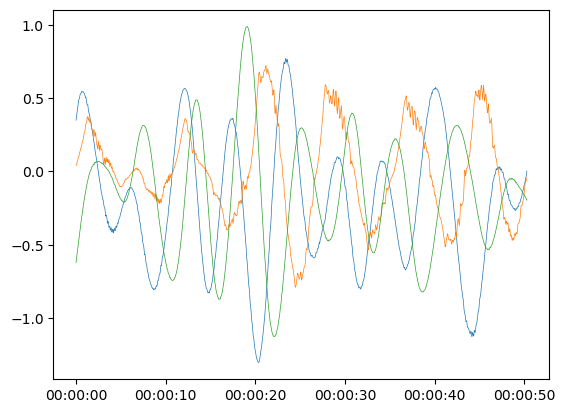

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x3493bffd0>

In [16]:
# read daily JLD2 example
dt = DateTime(2024, 5, 8)
yyyymmdd = Dates.format(dt, dateformat"yyyymmdd")
Vn = JLD2.load(joinpath(datadir, "VectorNavTable_$(yyyymmdd).jld2"))

st = 1; en = 1000
plot(Vn["time"][st:en], Vn["roll"][st:en], linewidth=0.5) # RollPitchYaw in degrees
plot(Vn["time"][st:en], Vn["pitch"][st:en], linewidth=0.5)
plot(Vn["time"][st:en], Vn["heave"][st:en], linewidth=0.5) # heave of the body in NED frame in m/s

## find displacements of sample volumes

In [24]:
rangegate = 24
range = 12.0 .+ 24.0.*((1:150).-1) # conflicts with Base.range

#=
heave = Vn[:VelNED2] # m/s?

# trigonometry to find displacements between volumes to be used in structure functions
target_vector(range, pitch, roll) = range .* [ -sin(pitch), cos(pitch)*sin(roll), cos(pitch)*cos(roll) ]
#simultaneous_vector(a1,a2, p1,p2, r1,r2) = target_vector(a1,p1,r1) .- target_vector(a2,p2,r2)
displacement_vector(X, Y, a1,a2, p1,p2, r1,r2) = [X, Y, 0] .- (target_vector(a1,p1,r1) .- target_vector(a2,p2,r2))
rad = abs(displacement_vector)
r1 = abs(displacement_vector[1])

function df(f, x::Vector)
    y = 
    for i = axes(x)
        for j = axes(x)[1:end]
            y = f( x[i] - x[j] )
        end
    end
    return y
end

"efficient representation of interaction of difference of vector u members"
Df(u) = UpperTriangular( (u .- permutedims(u)) )

# vectorize 3 levels of w
D2w = Df(w).^2
dx  = Df(x)
dy  = Df(y)
dz  = Df(z)
dist3 = norm()
=#

12.0:24.0:3588.0

In [19]:
#=
# address the time,height series with CartesianIndices?
ntime = 1000
nz = 150
nzoffset = 3
nind = ntime*(ntime+1)/2 * (nzoffset*nz - nzoffset*(nzoffset-1)/2)

function displacements_housekeeping(dt=0.5, range=12.0.+24.0.*((1:150).-1), U=10, V=10)
    ntime = 1000
    nz = 150
    nzoffset = 3
    nind = round(Int64, ntime*(ntime+1)/2 * (nzoffset*nz - nzoffset*(nzoffset-1)/2))
    
    # first housekeeping pass to estimate indices and displacements without data
    # and no angular corrections

    I = Vector{CartesianIndex{2}}(undef, nind)
    J = Vector{CartesianIndex{2}}(undef, nind)
    fill!(I, CartesianIndex(0,0))
    fill!(J, CartesianIndex(0,0))

    zm = Vector{Union{Missing,Float32}}(missing, nind)
    dz = Vector{Union{Missing,Float32}}(missing, nind)
    dr = Vector{Union{Missing,Float32}}(missing, nind)
    
    pitch = 0
    roll = 0
    X = 0.5
    Y = 0.5

    lin = 0 
    for it in 1:ntime
        for jt in (it+1):ntime # operate with all subsequent times
            for iz in 1:nz-2
                for jz in (iz+1):min(ntime, iz+2) # operate with next 3 levels
                    lin += 1
                    # I is first point, J is second point
                    I[lin] = CartesianIndex(it,iz)
                    J[lin] = CartesianIndex(it,jz)
                    zm[lin] = (range[iz] + range[jz]) / 2
                    dz[lin] =  range[iz] - range[jz]
                    dx = X
                    dy = Y
                    # distance between
                    dr[lin] = dz[lin]*dz[lin] + dx*dx * dy*dy
                end
            end
        end
    end

    return I,J, zm, dz,dr, lin
end

I,J, zm, dz,dr, lin = displacements_housekeeping()
# still not sure I'm counting the pairs correctly
=#

(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 2), CartesianIndex(1, 2), CartesianIndex(1, 3), CartesianIndex(1, 3), CartesianIndex(1, 4), CartesianIndex(1, 4), CartesianIndex(1, 5), CartesianIndex(1, 5)  …  CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0)], CartesianIndex{2}[CartesianIndex(1, 2), CartesianIndex(1, 3), CartesianIndex(1, 3), CartesianIndex(1, 4), CartesianIndex(1, 4), CartesianIndex(1, 5), CartesianIndex(1, 5), CartesianIndex(1, 6), CartesianIndex(1, 6), CartesianIndex(1, 7)  …  CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0)], Union{Missing, Float32}[24.0f0, 36.0f0, 48.0f0, 60.0f0, 72.0f0, 84.0f0, 96.

In [216]:
nt = 1000
nc = 3

# construct the indices of the combination sets
ci = CartesianIndices((nt,nc))
li = LinearIndices(ci)

# Generate the set of unique pairs of indices (l1,l2)
# where l1 < l2.
# Set() makes unique but it's slow and the result of the comprehension is already unique. 
lpairs = [ (l1, l2) for l1 in li[:] for l2 in (l1+1):last(li) ]
l1 = first.(lpairs) # vector of linear indices to points 1 of pairs
l2 =  last.(lpairs) #                             points 2
# str_fcn = w[ci[l1]] - w[ci[l2]])

# w can be indexed directly with ci[first.(lpairs])
# unpack the CartesianIndex to subscript the time, range
# idx[1] works but first(idx) tries to iterate which is unsupported
it1 = map(idx->idx[1], ci[l1]) #  t index of first point(s)
iz1 = map(idx->idx[2], ci[l1]) #  z index of first
it2 = map(idx->idx[1], ci[l2]) #  t       of second points(s)
iz2 = map(idx->idx[2], ci[l2]) #  z          second
#     first.(Tuple.(ci[l1])) # this also works


4498500-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3

In [20]:
# It might be fast enough to just move the pairing window up by 1 each time.
# But this will repeat some sample pairs: pairs in adjacent lines 2x, and in the same line 3x.
# To fix this, compute the unique set of pairs l1,l2 for the whole set of CartesianIndices 
# including z indices 1:nz. Then filter for the z index of ci[l2] to be <=3 from ci[l1].
# Generating this many pair is awfully slow. 
# There's no overlap if we generate pairs in sets of 3 levels, and go back to fill
## ci = CartesianIndices((nt,nz)) ## too slow

nt = 1000
nc = 3
islide = 0
# ci = CartesianIndices((nt,nc)) .+ CartesianIndex((0, islide))
# li = LinearIndices(ci)
# lpairs = [ (l1, l2) for l1 in li[:] for l2 in (l1+1):last(li) ] # redundancy

# The complete set that doesn't repeat pairs is 
# 1 the complete set of nt*(n-1)/2 pairs for the top level (3)
# 2 the 2*nt*nt sets of pairs between every point in top (3) level and the next 2 levels
# Iteratively slide this box upward by 1 level for each level.
"index unique pairs in a vector of length n"
function uniquepairs(n) 
    [ [l1, l2] for l1 in 1:n for l2 in (l1+1):n ]
end
"index pairs of points in adjacent levels"
allcross(n) = [ [l1, l2] for l1 in 1:n for l2 in 1:n ]

# index pairs in middle level 2-2
up = uniquepairs(nt)
it1 = map(i->i[1], up) # time indices for pairs of point1, point2
it2 = map(i->i[2], up)
ci1_r22 = CartesianIndex.(tuple.(it1,2)) # 1st point in pair lev
ci2_r22 = CartesianIndex.(tuple.(it2,2)) # 2nd 

# index pairs of points from level 2-1, and 2-3
ac = allcross(nt)
it1 = map(i->i[1], ac)
it2 = map(i->i[2], ac)
ci1_r21 = ci1_r23 = CartesianIndex.(tuple.(it1,2))
ci2_r21 = CartesianIndex.(tuple.(it2,1))
ci2_r23 = CartesianIndex.(tuple.(it2,3))

# omnibus set of cartesian index pairs for a level, including points in lev above and below
ci1 = [ci1_r23; ci1_r22; ci1_r21] # first of pairs
ci2 = [ci2_r23; ci2_r22; ci2_r21]
li1 = LinearIndices(ci1)
li2 = LinearIndices(ci2)

2499500-element LinearIndices{1, Tuple{Base.OneTo{Int64}}}:
       1
       2
       3
       4
       5
       6
       7
       8
       9
      10
      11
      12
      13
       ⋮
 2499489
 2499490
 2499491
 2499492
 2499493
 2499494
 2499495
 2499496
 2499497
 2499498
 2499499
 2499500

In [74]:
# just use one level
up = uniquepairs(nt)
it1 = map(i->i[1], up) # time indices for pairs of point1, point2
it2 = map(i->i[2], up)
ci1_r11 = CartesianIndex.(tuple.(it1,1)) # 1st point in pair lev
ci2_r11 = CartesianIndex.(tuple.(it2,1)) # 2nd 

# set of cartesian index pairs for a level, including points in lev above and below
ci1 = ci1_r11 # first of pairs
ci2 = ci2_r11
li1 = LinearIndices(ci1)
li2 = LinearIndices(ci2)

499500-element LinearIndices{1, Tuple{Base.OneTo{Int64}}}:
      1
      2
      3
      4
      5
      6
      7
      8
      9
     10
     11
     12
     13
      ⋮
 499489
 499490
 499491
 499492
 499493
 499494
 499495
 499496
 499497
 499498
 499499
 499500

In [75]:
it1 = map(idx->idx[1], ci1) #  t index of first point(s)
iz1 = map(idx->idx[2], ci1) #  z index of first
it2 = map(idx->idx[1], ci2) #  t       of second points(s)
iz2 = map(idx->idx[2], ci2) #  z          second

499500-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [76]:
# displacements with no adjustment for tilting into the horizontal wind 
# Udt, Vdt vary slowly; pitch,roll,w vary fast

"""
zm, dr2, dz2, D2 = displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate)
Displacements of sample pairs for one (vertical) subvolume.
"""
function displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate )
    # get the individual indices
    it1 = map(idx->idx[1], ci1) #  t index of first point(s)
    iz1 = map(idx->idx[2], ci1) #  z index of first
    it2 = map(idx->idx[1], ci2) #  t       of second points(s)
    iz2 = map(idx->idx[2], ci2) #  z          second

    rng(iz) = rangegate * (iz-1 + 0.5) # center of gates

    # horiz translation of the sample volumes by mean wind
    Udtbar = @. (Udt[iz2] + Udt[iz1]) / 2
    Vdtbar = @. (Vdt[iz2] + Vdt[iz1]) / 2
    X = @. Udtbar * (it2 - it1)
    Y = @. Vdtbar * (it2 - it1)
    # vertical middle of pair
    zm = @. (rng(iz2) * cos(pitch[it2])*cos(roll[it2]) + rng(iz1) * cos(pitch[it1])*cos(roll[it1])) / 2
    # displacement between pair of points
    dz = @.     rng(iz2) * cos(pitch[it2])*cos(roll[it2]) - rng(iz1) * cos(pitch[it1])*cos(roll[it1])
    dx = @. X + rng(iz2) *-sin(pitch[it2])                - rng(iz1) *-sin(pitch[it1])
    dy = @. Y + rng(iz2) * cos(pitch[it2])*sin(roll[it2]) - rng(iz1) * cos(pitch[it1])*sin(roll[it1])
    # distance between
    dz2 = dz .* dz
    dr2 = @. dz2 + dx*dx + dy*dy
    # vel structure function
    D2 = @. (w[ci2] - w[ci1])^2
    # return properties of pairs
    return zm, dr2, dz2, D2
end

"dr^2/3 (1-(dz/dr)^2/4) displacement function for computing dissipation from structure function pairs"
rhopair(dr2, dz2) = dr2^(1/3) * (1 - dz2/(4*dr2))

rhopair

In [77]:
# test the logic by computing with dummy data
nz = 150
w = zeros(nt,nz)
Udt = 5.0 .+ zeros(nz)
Vdt = 5.0 .+ zeros(nz)
pitch = @. 10*pi/180 * sin((1:nt)*pi/10) # fake
roll  = @. 10*pi/180 * cos((1:nt)*pi/10)

zm, dr2, dz2, D2 = displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate )


([11.817982128203518, 11.817982128203518, 11.817852842269513, 11.817772939208005, 11.817852842269513, 11.817982128203518, 11.817982128203518, 11.817852842269515, 11.817772939208005, 11.817852842269513  …  11.817982128203516, 11.817982128203516, 11.817852842269513, 11.817772939208005, 11.818111414137519, 11.817982128203516, 11.817902225142007, 11.817982128203516, 11.817902225142007, 11.817772939208005], [41.60892235148373, 165.56618916638564, 373.2530801612619, 669.3141843344615, 1060.9511284580296, 1556.997976965279, 2166.808405320483, 2898.900254753664, 3759.4234181093752, 4750.7572886879725  …  53.26818337860324, 207.41469221877617, 453.76540289876505, 784.54262777845, 50.45958740461272, 196.0943665565296, 428.95391361097325, 47.60838001704101, 185.1729869202623, 44.99943919594262], [6.685941092315753e-8, 6.685941092315753e-8, 3.1554436208840472e-30, 2.5537996954371423e-8, 3.1554436208840472e-30, 6.685941092315753e-8, 6.685941092315753e-8, 0.0, 2.5537996954371423e-8, 3.15544362088404

In [97]:
rho = rhopair.(dr2, dz2)
#plot((1:length(rho))/length(rho), sort(rho))

# devise equally-populated bins
nrho = length(rho)
nbin = 20
sp = sortperm(rho)
srho = rho[sp]
rhobins = [ 0; rho[sp[Int32(nrho/20):Int32(nrho/20):nrho]] ]
# maximum(rho), sort(rho)[length(rho)]
# plot(rhopair.(dr2, dz2), zm, marker=".", linestyle="none")
# hist(rhopair.(dr2, dz2), bins=20)

# bin average y in bins of x
function binavg(y, x, b)
    a = zeros(length(b))
    c = zeros(length(b))
    for (i,x) in enumerate(x)
        bi = findlast(j -> j < x, b)
        a[bi] += y[i]
        c[bi] += 1
    end
    return a./c
end

D2bin = binavg(rand(length(rho)), rho, rhobins)

21-element Vector{Float64}:
   0.5011519448338186
   0.4999114056422025
   0.502889482573963
   0.5024909566945889
   0.5021074583191569
   0.4990818258293421
   0.5016916866736525
   0.5029742832878987
   0.4985054101735766
   0.5022302415769619
   0.4979960591945028
   0.5039502632839588
   0.5006210530627802
   0.5003313080284651
   0.5020551011563921
   0.5025498290622787
   0.5003079689029826
   0.5000752475035021
   0.49981572721669687
   0.5004674802523021
 NaN

In [ ]:

# plot some of this stuff
# drcount, bins = hist((dr[:]), bins=80, range=(30, (X*nt*1.4)))
dzcount, bins = hist((dz[:]), bins=80, range=(0, (2*24)))
title("displacement between point pairs")
clf()
plot(dz./dr, dz, marker=".", linestyle="none")


In [ ]:

    dz = Float32
    for it in 1:ntime
        for jt in (it+1):ntime # operate with all subsequent times
            for iz in 1:nz-2
                for jz in (iz+1):min(ntime, iz+2) # operate with next 3 levels
                    # i is first point, j is second point

                    # mean wind translation
                    X = U * dt*(jt-it)
                    Y = V * dt*(jt-it)
                    # middle of pair
                    zm =    (range[iz] * cos(pitch[it])*cos(roll[it]) + range[jz] * cos(pitch[jt])*cos(roll[jt])) / 2
                    # displacement between pair of points
                    dz =     range[iz] * cos(pitch[it])*cos(roll[it]) - range[jz] * cos(pitch[jt])*cos(roll[jt])
                    dx = X + range[iz] *-sin(pitch[it])               - range[jz] *-sin(pitch[jt])
                    dy = Y + range[iz] * cos(pitch[it])*sin(roll[it]) - range[jz] * cos(pitch[jt])*sin(roll[jt])
                    # distance between
                    dr = dz*dz + dx*dx * dy*dy
                    # vel structure function
                    D2 = (w[it,iz] - w[jt,jz])^2
                end
            end
        end
    end
end

function displacements_D2(dt=0.5, range=12.0.+24.0.*((1:150).-1), U=10, V=10)
    for it in 1:ntime
        for jt in (it+1):ntime # operate with all subsequent times
            for iz in 1:nz-2
                for jz in (iz+1):min(ntime, iz+2) # operate with next 3 levels
                    # i is first point, j is second point

                    # mean wind translation
                    X = U * dt*(jt-it)
                    Y = V * dt*(jt-it)
                    # middle of pair
                    zm =    (range[iz] * cos(pitch[it])*cos(roll[it]) + range[jz] * cos(pitch[jt])*cos(roll[jt])) / 2
                    # displacement between pair of points
                    dz =     range[iz] * cos(pitch[it])*cos(roll[it]) - range[jz] * cos(pitch[jt])*cos(roll[jt])
                    dx = X + range[iz] *-sin(pitch[it])               - range[jz] *-sin(pitch[jt])
                    dy = Y + range[iz] * cos(pitch[it])*sin(roll[it]) - range[jz] * cos(pitch[it1])*sin(roll[jt])
                    # distance between
                    dr = dz*dz + dx*dx * dy*dy
                    # vel structure function
                    D2 = (w[it,iz] - w[jt,jz])^2
                end
            end
        end
    end
end

# I don't know how to do this with CartesianIndices
I = CartesianIndices([(it, iz) for iz=1:nlev-2, it in 1:ntime]) # seems OK
J = I + CartesianIndex(1:ntime-1, )

In [ ]:

#=
% turbulece constants
crosscomp  = 3 / 4;
kolmogorov = 0.54; % Matches atmospheric boundary layer estimates and Sreenivasan 1995
% kolmogorov=0.5; % probably only 1 digit of precision, Sreenivasan 1995
C1prime = 4 / 3 * kolmogorov; % as in Pope eqn 6.243
factr   = crosscomp / kolmogorov; % 1/C1prime, used for my dissipation calculation
% S(w; k) = C1primt * epsilon^2/3 k^-5/3
% universal constant for 2nd order structure function
% longitudinal structure function constant C2 from Pope 6.2 (p.193) after Saddoughi and Veeravalli (1994)

factrz = 1 / C2ll;
factrx = 3 / 4 / C2ll;
=#

# stucture function
C2ll = 2.0
struf(epsilon, r,r1) = C2ll epsilon^(2/3) r^(2/3) (4 - (r1/r)^2)/3
instruf(w1,w2) = (w1-w2)^2
rho(r1,r) = r^(2/3) * (1 - ((r1/r)^2)/4)
zmid(z1,z2) = (z1 + z2) / 2
# plot bin averaged instruf vs rho
# fit 
# D = A*rho + noise
# for A and noise
# A = 4/3 * C2ll * epsilon^(2/3)
epsilon(A) = sqrt(3/4 * A/C2ll)^3